# Multi‑Agent LLM Judge — Log Parser

این نوت‌بوک برای **خواندن لاگ‌های اجرای ارزیابی** و **استخراج خودکار اطلاعات** زیر طراحی شده است:

- مسیر و تعداد نمونه‌های بارگذاری‌شده از دیتاست‌ها
- مدل‌های در دسترس و مدل کالیبراسیون استفاده‌شده
- عامل‌های ثبت‌شده (Agents) و اعضای هیئت منصفه (Jurors)
- خلاصهٔ هر نمونهٔ ارزیابی‌شده: حکم نهایی (Pipeline verdict)، صحت نسبت به واقعیت (Ground truth)، درست/غلط بودن حکم، اطمینان (Confidence)، اجماع (Consensus)
- آمارهای گردآوری‌شده: شمارش‌ها، میانگین اطمینان، توزیع، و …
- خروجی CSV برای استفادهٔ بعدی

> **راهنما:** در سلول «پارامترها» مسیر فایل لاگ خودتان را وارد کنید (یا چند مسیر). سپس سلول‌ها را به ترتیب اجرا کنید.


## پیش‌نیازها

این نوت‌بوک از کتابخانه‌های استاندارد پایتون به‌علاوهٔ `pandas` و `matplotlib` استفاده می‌کند.


In [ ]:
# اگر نیاز بود:
# %pip install pandas matplotlib
import re
import os
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# برای نمایش DataFrame به صورت جدول تعاملی در محیط شما
from caas_jupyter_tools import display_dataframe_to_user


## پارامترها

- `LOG_FILES`: لیست مسیر فایل‌های لاگ که باید پردازش شوند.
- اگر نمی‌خواهید فایل‌ها را بخوانید، می‌توانید رشتهٔ لاگ را مستقیماً در `RAW_LOG_SAMPLE` قرار دهید.


In [ ]:
# --- پارامترها ---
LOG_FILES = [
    # نمونه:
    # "/home/zeus/Projects/hb/multi_agent_llm_judge/logs/eval_20250922.log",
]

# اگر خواستید سریع تست کنید، چند خط لاگ را مستقیم اینجا بگذارید:
RAW_LOG_SAMPLE = \"\"\"
2025-09-22 22:30:59.211 | INFO     | __main__:run_evaluation:2521 - Loaded 1000 examples from /home/.../hotpotqa_with_verdict_with_gold.json
2025-09-22 22:31:00.534 | INFO     | multi_agent_llm_judge.core.model_manager:initialize:73 - Initialized with 325 available models
2025-09-22 22:31:00.537 | INFO     | multi_agent_llm_judge.jury.jury_manager:__init__:36 - Created 3 jurors with diverse models:
2025-09-22 22:31:00.537 | INFO     | multi_agent_llm_judge.jury.jury_manager:__init__:41 -   - 1 jurors using openai/gpt-4.1-nano
2025-09-22 22:31:00.537 | INFO     | multi_agent_llm_judge.jury.jury_manager:__init__:41 -   - 1 jurors using google/gemini-flash-1.5-8b
2025-09-22 22:31:00.537 | INFO     | multi_agent_llm_judge.jury.jury_manager:__init__:41 -   - 1 jurors using x-ai/grok-4-fast:free
2025-09-22 22:31:00.546 | INFO     | multi_agent_llm_judge.core.round_manager:__init__:56 - Loaded calibration model from /home/.../ensemble_calibrator.pkl
2025-09-22 22:31:00.557 | INFO     | __main__:run_evaluation:2541 -   Pipeline verdict: True (Ground truth: True)
2025-09-22 22:31:00.556 | INFO     | __main__:run_evaluation:2543 -   Confidence: 88.31%
2025-09-22 22:31:00.556 | INFO     | __main__:run_evaluation:2544 -   Consensus: 100.00%
2025-09-22 22:31:00.557 | INFO     | __main__:run_evaluation:2545 -   Agents: 14 across 2 rounds
2025-09-22 22:31:00.557 | INFO     | __main__:run_evaluation:2552 -     Round 1: 7 agents, avg conf: 55.71%
2025-09-22 22:31:00.557 | INFO     | __main__:run_evaluation:2553 -       Verdicts: {'correct': 2, 'incorrect': 0, 'uncertain': 5}
2025-09-22 22:31:00.557 | INFO     | __main__:run_evaluation:2558 -         ChainOfThoughtAgent (ChainOfThoughtAgent): correct (conf: 60.00%)
\"\"\"


## توابع parsing

در این بخش الگوهای `regex` تعریف و توابعی برای استخراج رویدادها و خلاصه‌ها پیاده‌سازی می‌شود.


In [ ]:
# الگوهای Regex
RE_DATASET_LOAD = re.compile(
    r"Loaded\s+(?P<count>\d+)\s+examples\s+from\s+(?P<path>\S+)"
)
RE_MODELS_INIT = re.compile(
    r"Initialized with\s+(?P<n_models>\d+)\s+available models"
)
RE_CALIB_MODEL = re.compile(
    r"Loaded calibration model from\s+(?P<path>\S+)"
)
RE_JUROR_CREATED = re.compile(
    r"Created\s+(?P<count>\d+)\s+jurors"
)
RE_JUROR_LINE = re.compile(
    r"-\s+1\s+jurors\s+using\s+(?P<model>.+)$"
)
RE_AGENT_REGISTERED = re.compile(
    r"Registered agent:\s+(?P<atype>AgentType\.[A-Z_]+)\s+->\s+(?P<aclass>\w+)"
)
RE_EXAMPLE_HDR = re.compile(
    r"Evaluating example\s+(?P<idx>\d+)/(?P<total>\d+)\s+-\s+ID:\s+(?P<id>\w+)"
)
RE_PIPELINE_VERDICT = re.compile(
    r"Pipeline verdict:\s+(?P<pred>\w+)\s+\(Ground truth:\s+(?P<gt>\w+)\)"
)
RE_VERDICT_CORRECT = re.compile(
    r"Verdict correct:\s+(?P<is_correct>\w+)"
)
RE_CONFIDENCE = re.compile(
    r"Confidence:\s+(?P<conf>[0-9.]+)%"
)
RE_CONSENSUS = re.compile(
    r"Consensus:\s+(?P<cons>[0-9.]+)%"
)
RE_AGENTS_ROUNDS = re.compile(
    r"Agents:\s+(?P<n_agents>\d+)\s+across\s+(?P<n_rounds>\d+)\s+rounds"
)
RE_ROUND_HDR = re.compile(
    r"Round\s+(?P<ridx>\d+):\s+(?P<n_agents>\d+)\s+agents,\s+avg conf:\s+(?P<avgconf>[0-9.]+)%"
)
RE_ROUND_VERDICTS = re.compile(
    r"Verdicts:\s+\{'correct':\s*(?P<c>\d+),\s*'incorrect':\s*(?P<i>\d+),\s*'uncertain':\s*(?P<u>\d+)\}"
)
RE_AGENT_LINE = re.compile(
    r"^\s{8,}(?P<name>\w+)\s+\(\w+\):\s+(?P<verdict>correct|incorrect|uncertain)\s+\(conf:\s+(?P<conf>[0-9.]+)%\)"
)

def read_logs_from_files(files: List[str]) -> str:
    contents = []
    for p in files:
        pth = Path(p)
        if pth.exists():
            contents.append(pth.read_text(encoding="utf-8", errors="ignore"))
        else:
            print(f"[WARN] File not found: {p}")
    return "\n".join(contents)

def normalize_lines(text: str) -> List[str]:
    return [ln.rstrip("\n") for ln in text.splitlines()]

def parse_logs(lines: List[str]) -> Dict[str, Any]:
    data: Dict[str, Any] = {
        "datasets": [],
        "models_available": None,
        "calibration_model_path": None,
        "juror_count": None,
        "juror_models": [],
        "agents_registered": [],
        "examples": [],  # list of per-example dicts
    }

    current_example: Dict[str, Any] = {}
    round_buffer: List[Dict[str, Any]] = []

    for ln in lines:
        # Datasets
        m = RE_DATASET_LOAD.search(ln)
        if m:
            data["datasets"].append({
                "count": int(m.group("count")),
                "path": m.group("path")
            })
            continue

        # Models available
        m = RE_MODELS_INIT.search(ln)
        if m:
            data["models_available"] = int(m.group("n_models"))
            continue

        # Calibration model
        m = RE_CALIB_MODEL.search(ln)
        if m:
            data["calibration_model_path"] = m.group("path")
            continue

        # Jurors
        m = RE_JUROR_CREATED.search(ln)
        if m:
            data["juror_count"] = int(m.group("count"))
            continue
        m = RE_JUROR_LINE.search(ln)
        if m:
            data["juror_models"].append(m.group("model").strip())
            continue

        # Agents registered
        m = RE_AGENT_REGISTERED.search(ln)
        if m:
            data["agents_registered"].append({
                "type": m.group("atype"),
                "class": m.group("aclass")
            })
            continue

        # Example header
        m = RE_EXAMPLE_HDR.search(ln)
        if m:
            # flush previous example
            if current_example:
                if round_buffer:
                    current_example["rounds"] = round_buffer
                data["examples"].append(current_example)
                current_example = {}
                round_buffer = []
            current_example = {
                "index": int(m.group("idx")),
                "total": int(m.group("total")),
                "id": m.group("id"),
            }
            continue

        # Example fields
        if current_example:
            m = RE_PIPELINE_VERDICT.search(ln)
            if m:
                current_example["pipeline_verdict"] = m.group("pred")
                current_example["ground_truth"] = m.group("gt")
                continue
            m = RE_VERDICT_CORRECT.search(ln)
            if m:
                current_example["verdict_correct"] = (m.group("is_correct").lower() == "true")
                continue
            m = RE_CONFIDENCE.search(ln)
            if m:
                current_example["confidence_pct"] = float(m.group("conf"))
                continue
            m = RE_CONSENSUS.search(ln)
            if m:
                current_example["consensus_pct"] = float(m.group("cons"))
                continue
            m = RE_AGENTS_ROUNDS.search(ln)
            if m:
                current_example["n_agents"] = int(m.group("n_agents"))
                current_example["n_rounds"] = int(m.group("n_rounds"))
                continue
            m = RE_ROUND_HDR.search(ln)
            if m:
                round_buffer.append({
                    "round_idx": int(m.group("ridx")),
                    "n_agents": int(m.group("n_agents")),
                    "avg_conf_pct": float(m.group("avgconf")),
                    "verdicts": None,
                    "agents": []
                })
                continue
            m = RE_ROUND_VERDICTS.search(ln)
            if m and round_buffer:
                round_buffer[-1]["verdicts"] = {
                    "correct": int(m.group("c")),
                    "incorrect": int(m.group("i")),
                    "uncertain": int(m.group("u"))
                }
                continue
            m = RE_AGENT_LINE.search(ln)
            if m and round_buffer:
                round_buffer[-1]["agents"].append({
                    "name": m.group("name"),
                    "verdict": m.group("verdict"),
                    "conf_pct": float(m.group("conf"))
                })
                continue

    # flush last example
    if current_example:
        if round_buffer:
            current_example["rounds"] = round_buffer
        data["examples"].append(current_example)

    return data


## اجرای پارسینگ

با اجرای سلول زیر، لاگ‌ها خوانده و ساختاردهی می‌شوند.


In [ ]:
# جمع‌آوری ورودی
if LOG_FILES:
    raw_text = read_logs_from_files(LOG_FILES)
else:
    raw_text = RAW_LOG_SAMPLE

lines = normalize_lines(raw_text)
parsed = parse_logs(lines)

# نمایش خلاصه
print("Datasets loaded:")
for d in parsed["datasets"]:
    print(f"  - {d['path']} (count={d['count']})")

print("\nModels available:", parsed["models_available"])
print("Calibration model:", parsed["calibration_model_path"])
print("Juror count:", parsed["juror_count"])
print("Juror models:", parsed["juror_models"])

print("\nAgents registered (first 10):")
for a in parsed["agents_registered"][:10]:
    print(" ", a)

print(f"\nTotal examples parsed: {len(parsed['examples'])}")
if parsed["examples"]:
    print("First example keys:", list(parsed["examples"][0].keys()))


## ساخت DataFrame و خروجی CSV

در این بخش داده‌ها به صورت جدول‌های پانداس در می‌آید و در صورت نیاز به CSV خروجی گرفته می‌شود.


In [ ]:
# Agents registered
df_agents = pd.DataFrame(parsed["agents_registered"])
if not df_agents.empty:
    display_dataframe_to_user("Agents Registered", df_agents)

# Datasets
df_datasets = pd.DataFrame(parsed["datasets"])
if not df_datasets.empty:
    display_dataframe_to_user("Datasets Loaded", df_datasets)

# Examples (flat summary)
def examples_to_rows(examples: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    rows = []
    for ex in examples:
        row = {
            "index": ex.get("index"),
            "total": ex.get("total"),
            "id": ex.get("id"),
            "pipeline_verdict": ex.get("pipeline_verdict"),
            "ground_truth": ex.get("ground_truth"),
            "verdict_correct": ex.get("verdict_correct"),
            "confidence_pct": ex.get("confidence_pct"),
            "consensus_pct": ex.get("consensus_pct"),
            "n_agents": ex.get("n_agents"),
            "n_rounds": ex.get("n_rounds"),
        }
        rows.append(row)
    return rows

df_examples = pd.DataFrame(examples_to_rows(parsed["examples"]))
if not df_examples.empty:
    display_dataframe_to_user("Example-Level Summary", df_examples)

# Round-level explode
round_records = []
for ex in parsed["examples"]:
    ex_id = ex.get("id")
    for rd in ex.get("rounds", []) if ex.get("rounds") else []:
        rec = {
            "example_id": ex_id,
            "round_idx": rd.get("round_idx"),
            "round_avg_conf_pct": rd.get("avg_conf_pct"),
            "round_correct": rd.get("verdicts", {}).get("correct") if rd.get("verdicts") else None,
            "round_incorrect": rd.get("verdicts", {}).get("incorrect") if rd.get("verdicts") else None,
            "round_uncertain": rd.get("verdicts", {}).get("uncertain") if rd.get("verdicts") else None,
        }
        round_records.append(rec)

df_rounds = pd.DataFrame(round_records)
if not df_rounds.empty:
    display_dataframe_to_user("Round-Level Summary", df_rounds)

# Agent-level within rounds
agent_records = []
for ex in parsed["examples"]:
    ex_id = ex.get("id")
    for rd in ex.get("rounds", []) if ex.get("rounds") else []:
        for ag in rd.get("agents", []) if rd.get("agents") else []:
            agent_records.append({
                "example_id": ex_id,
                "round_idx": rd.get("round_idx"),
                "agent_name": ag.get("name"),
                "agent_verdict": ag.get("verdict"),
                "agent_conf_pct": ag.get("conf_pct"),
            })
df_round_agents = pd.DataFrame(agent_records)
if not df_round_agents.empty:
    display_dataframe_to_user("Per-Round Agent Details", df_round_agents)

# ذخیره CSVها
out_dir = Path("/mnt/data/log_parse_exports")
out_dir.mkdir(parents=True, exist_ok=True)

paths = {}
if not df_agents.empty:
    paths["agents_csv"] = str(out_dir / "agents_registered.csv")
    df_agents.to_csv(paths["agents_csv"], index=False)
if not df_datasets.empty:
    paths["datasets_csv"] = str(out_dir / "datasets_loaded.csv")
    df_datasets.to_csv(paths["datasets_csv"], index=False)
if not df_examples.empty:
    paths["examples_csv"] = str(out_dir / "example_level_summary.csv")
    df_examples.to_csv(paths["examples_csv"], index=False)
if not df_rounds.empty:
    paths["rounds_csv"] = str(out_dir / "round_level_summary.csv")
    df_rounds.to_csv(paths["rounds_csv"], index=False)
if not df_round_agents.empty:
    paths["round_agents_csv"] = str(out_dir / "per_round_agent_details.csv")
    df_round_agents.to_csv(paths["round_agents_csv"], index=False)

print("Saved files:")
print(json.dumps(paths, indent=2, ensure_ascii=False))


## نمودارها

چند نمودار ساده برای بررسی توزیع اطمینان و نسبت درست/نادرست.


In [ ]:
# نمودار توزیع اطمینان (اگر داده موجود باشد)
if not df_examples.empty and "confidence_pct" in df_examples.columns:
    vals = df_examples["confidence_pct"].dropna().values
    if len(vals) > 0:
        plt.figure()
        plt.hist(vals, bins=20)
        plt.title("Confidence % Distribution")
        plt.xlabel("Confidence (%)")
        plt.ylabel("Count")
        plt.show()

# نمودار تعداد verdict_correct True/False
if not df_examples.empty and "verdict_correct" in df_examples.columns:
    counts = df_examples["verdict_correct"].value_counts(dropna=False)
    plt.figure()
    counts.plot(kind="bar")
    plt.title("Verdict Correct Counts")
    plt.xlabel("Is Correct")
    plt.ylabel("Count")
    plt.show()


## ذخیرهٔ نوت‌بوک

این سلول، همین نوت‌بوک را به صورت فایل `.ipynb` ذخیره می‌کند تا بعداً آن را دانلود یا اجرا کنید.


In [ ]:
nb_path = Path("/mnt/data/llm_judge_log_parser.ipynb")
nb = new_notebook(cells=nb_cells, metadata={"kernelspec": {"name": "python3", "display_name": "Python 3"}})
with nb_path.open("w", encoding="utf-8") as f:
    nbformat.write(nb, f)
print(f"Notebook saved to: {nb_path}")


In [5]:
import re
from collections import Counter
import pandas as pd

def extract_voting_and_gold_info(block):
    """
    از یک بلوک، اطلاعات رای‌گیری مدل‌ها و Gold verdict را استخراج می‌کند
    """
    # استخراج Gold verdict (برچسب واقعی)
    gold_match = re.search(r'Gold verdict:\s*(True|False)', block)
    if not gold_match:
        return None, None
    
    # تبدیل True/False به correct/incorrect
    gold_verdict = 'correct' if gold_match.group(1) == 'True' else 'incorrect'
    
    # استخراج رای‌های مدل‌ها
    votes = {'correct': 0, 'incorrect': 0, 'uncertain': 0}
    
    # پیدا کردن بخش رای‌گیری
    voting_start = block.find('Model voting distribution:')
    if voting_start == -1:
        return gold_verdict, None
    
    # یافتن پایان بخش رای‌گیری (تا خط بعدی که با تاریخ شروع می‌شود یا پایان بلوک)
    voting_end = block.find('\n2025-', voting_start)
    if voting_end == -1:
        voting_section = block[voting_start:]
    else:
        voting_section = block[voting_start:voting_end]
    
    # استخراج رای هر مدل با الگوی دقیق
    # مثال: openai/gpt-4.1-nano: {'correct': 0, 'incorrect': 1, 'uncertain': 0}
    model_vote_pattern = r"[\w\-\/\.:]+:\s*{'correct':\s*(\d+),\s*'incorrect':\s*(\d+),\s*'uncertain':\s*(\d+)}"
    matches = re.findall(model_vote_pattern, voting_section)
    
    for match in matches:
        correct_vote = int(match[0])
        incorrect_vote = int(match[1])
        uncertain_vote = int(match[2])
        
        # هر مدل دقیقاً یک رای دارد (یکی از مقادیر باید 1 باشد)
        if correct_vote == 1:
            votes['correct'] += 1
        elif incorrect_vote == 1:
            votes['incorrect'] += 1
        elif uncertain_vote == 1:
            votes['uncertain'] += 1
    
    # بررسی اینکه آیا رای‌ها استخراج شدند
    total_votes = votes['correct'] + votes['incorrect'] + votes['uncertain']
    if total_votes == 0:
        return gold_verdict, None
    
    return gold_verdict, votes

def extract_verdict_correct(block):
    """
    استخراج مقدار Verdict correct از بلوک
    """
    verdict_match = re.search(r'Verdict correct:\s*(True|False)', block)
    if verdict_match:
        return verdict_match.group(1) == 'True'
    return None

def determine_majority_vote(votes):
    """
    تعیین رای اکثریت بر اساس آرای مدل‌ها
    """
    total_votes = votes['correct'] + votes['incorrect'] + votes['uncertain']
    
    if total_votes == 0:
        return 'no_vote'
    
    # محاسبه رای اکثریت
    if votes['correct'] > votes['incorrect'] and votes['correct'] > votes['uncertain']:
        return 'correct'
    elif votes['incorrect'] > votes['correct'] and votes['incorrect'] > votes['uncertain']:
        return 'incorrect'
    elif votes['uncertain'] > votes['correct'] and votes['uncertain'] > votes['incorrect']:
        return 'uncertain'
    else:
        # در صورت تساوی
        if votes['correct'] == votes['incorrect']:
            return 'tie_correct_incorrect'
        elif votes['correct'] == votes['uncertain']:
            return 'tie_correct_uncertain'
        elif votes['incorrect'] == votes['uncertain']:
            return 'tie_incorrect_uncertain'
        else:
            return 'tie_all'

def calculate_accuracy_with_majority_voting(log_file_path):
    """
    فایل لاگ را می‌خواند، بلوک‌های ارزیابی کامل را پیدا می‌کند،
    و دقت، صحت و بازخوانی را بر اساس رای اکثریت و Gold verdict محاسبه می‌کند.
    """
    print(f"جستجو در فایل '{log_file_path}' برای محاسبه معیارها با رای اکثریت...\n")

    try:
        with open(log_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"خطا: فایل '{log_file_path}' یافت نشد.")
        return None, None

    # جداکننده بلوک‌های ارزیابی
    separator = "============================================================"
    
    # محتوای فایل را به بلوک‌های مجزا تقسیم می‌کنیم
    blocks = content.split(separator)[1:]  # بلوک اول را حذف می‌کنیم
    
    # لیست برای ذخیره نتایج
    results = []
    
    # شمارنده‌ها برای confusion matrix
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    uncertain_count = 0
    tie_count = 0
    
    # تحلیل هر بلوک
    processed_blocks = 0
    for i, block in enumerate(blocks):
        # فقط بلوک‌های کامل را بررسی می‌کنیم
        if "Model voting distribution:" in block and "Gold verdict:" in block:
            gold_verdict, votes = extract_voting_and_gold_info(block)
            verdict_correct = extract_verdict_correct(block)
            
            if gold_verdict is not None and votes is not None:
                processed_blocks += 1
                
                # محاسبه رای اکثریت
                majority_vote = determine_majority_vote(votes)
                
                # محاسبه TP, TN, FP, FN
                prediction_status = None
                prediction_correct = None
                
                if 'tie' in majority_vote:
                    tie_count += 1
                    prediction_status = 'Tie'
                elif majority_vote == 'uncertain':
                    uncertain_count += 1
                    prediction_status = 'Uncertain'
                else:
                    if gold_verdict == 'correct' and majority_vote == 'correct':
                        true_positives += 1
                        prediction_status = 'TP'
                        prediction_correct = True
                    elif gold_verdict == 'incorrect' and majority_vote == 'incorrect':
                        true_negatives += 1
                        prediction_status = 'TN'
                        prediction_correct = True
                    elif gold_verdict == 'incorrect' and majority_vote == 'correct':
                        false_positives += 1
                        prediction_status = 'FP'
                        prediction_correct = False
                    elif gold_verdict == 'correct' and majority_vote == 'incorrect':
                        false_negatives += 1
                        prediction_status = 'FN'
                        prediction_correct = False
                
                # ذخیره نتایج
                results.append({
                    'بلوک': i + 1,
                    'رای_درست': votes['correct'],
                    'رای_غلط': votes['incorrect'],
                    'رای_نامشخص': votes['uncertain'],
                    'مجموع_آرا': votes['correct'] + votes['incorrect'] + votes['uncertain'],
                    'رای_اکثریت': majority_vote,
                    'gold_verdict': gold_verdict,
                    'verdict_correct': verdict_correct,
                    'وضعیت_پیش‌بینی': prediction_status,
                    'پیش‌بینی_صحیح': prediction_correct
                })
    
    # نمایش جدول نتایج
    if not results:
        print("هیچ بلوک کاملی برای تحلیل یافت نشد.")
        return None, None
    
    # ایجاد DataFrame
    df = pd.DataFrame(results)
    
    print("=== جدول تفصیلی نتایج (نمونه‌ای از داده‌ها) ===")
    print(df.head(20).to_string(index=False))
    if len(df) > 20:
        print(f"\n... و {len(df) - 20} ردیف دیگر")
    
    # نمایش Confusion Matrix
    print("\n=== Confusion Matrix ===")
    print(f"True Positives (TP): {true_positives}")
    print(f"True Negatives (TN): {true_negatives}")
    print(f"False Positives (FP): {false_positives}")
    print(f"False Negatives (FN): {false_negatives}")
    print(f"Uncertain predictions: {uncertain_count}")
    print(f"Tie cases: {tie_count}")
    
    # محاسبه معیارهای ارزیابی
    total_decisive_predictions = true_positives + true_negatives + false_positives + false_negatives
    
    if total_decisive_predictions > 0:
        # Accuracy = (TP + TN) / (TP + TN + FP + FN)
        accuracy = (true_positives + true_negatives) / total_decisive_predictions * 100
        
        # Precision = TP / (TP + FP)
        if (true_positives + false_positives) > 0:
            precision = (true_positives / (true_positives + false_positives)) * 100
        else:
            precision = 0
        
        # Recall = TP / (TP + FN)
        if (true_positives + false_negatives) > 0:
            recall = (true_positives / (true_positives + false_negatives)) * 100
        else:
            recall = 0
        
        # F1 Score
        if (precision + recall) > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        
        print("\n=== معیارهای ارزیابی (بدون احتساب موارد نامشخص و تساوی) ===")
        print(f"دقت (Accuracy): {accuracy:.2f}%")
        print(f"صحت (Precision): {precision:.2f}%")
        print(f"بازخوانی (Recall): {recall:.2f}%")
        print(f"F1 Score: {f1_score:.2f}%")
    
    # آمارهای کلی
    print(f"\n=== آمارهای کلی ===")
    total_blocks = len(results)
    correct_predictions = sum(1 for r in results if r['پیش‌بینی_صحیح'] == True)
    incorrect_predictions = sum(1 for r in results if r['پیش‌بینی_صحیح'] == False)
    
    print(f"تعداد کل بلوک‌های تحلیل شده: {total_blocks}")
    print(f"تعداد بلوک‌های پردازش شده: {processed_blocks}")
    print(f"تعداد پیش‌بینی‌های صحیح: {correct_predictions}")
    print(f"تعداد پیش‌بینی‌های غلط: {incorrect_predictions}")
    print(f"تعداد موارد نامشخص: {uncertain_count}")
    print(f"تعداد موارد تساوی: {tie_count}")
    
    # توزیع Gold verdict
    print("\n=== توزیع Gold verdict ===")
    gold_distribution = Counter(r['gold_verdict'] for r in results)
    for verdict_type, count in gold_distribution.items():
        percentage = (count / total_blocks) * 100
        print(f"{verdict_type}: {count} ({percentage:.1f}%)")
    
    # توزیع رای‌های اکثریت
    print("\n=== توزیع رای‌های اکثریت ===")
    majority_distribution = Counter(r['رای_اکثریت'] for r in results)
    for vote_type, count in majority_distribution.items():
        percentage = (count / total_blocks) * 100
        print(f"{vote_type}: {count} ({percentage:.1f}%)")
    
    # نمایش تعداد مدل‌های رای‌دهنده در هر بلوک
    vote_counts = Counter(r['مجموع_آرا'] for r in results)
    print("\n=== توزیع تعداد مدل‌های رای‌دهنده ===")
    for num_models, count in sorted(vote_counts.items()):
        percentage = (count / total_blocks) * 100
        print(f"{num_models} مدل: {count} مورد ({percentage:.1f}%)")
    
    return df, results

# --- اجرا ---
log_file_to_analyze = '/home/zeus/Projects/hb/multi_agent_llm_judge/app3-full7k-hotpotqa.log'

# اجرای تحلیل
result = calculate_accuracy_with_majority_voting(log_file_to_analyze)

if result[0] is not None:
    df, results = result
    
    # ذخیره نتایج در فایل CSV
    output_file = 'majority_voting_analysis.csv'
    df.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\nنتایج در فایل '{output_file}' ذخیره شد.")
else:
    print("تحلیل با مشکل مواجه شد.")


جستجو در فایل '/home/zeus/Projects/hb/multi_agent_llm_judge/app3-full7k-hotpotqa.log' برای محاسبه معیارها با رای اکثریت...

هیچ بلوک کاملی برای تحلیل یافت نشد.
تحلیل با مشکل مواجه شد.


In [11]:
import re
import pandas as pd
from collections import defaultdict
import json

def extract_evaluation_data_comprehensive(log_file_path):
    """
    استخراج جامع همه اطلاعات ارزیابی در یک DataFrame
    """
    print(f"در حال خواندن فایل: {log_file_path}")
    
    try:
        with open(log_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"خطا: فایل '{log_file_path}' یافت نشد.")
        return None
    
    # جداکننده بلوک‌ها
    separator = "=" * 60
    blocks = content.split(separator)
    
    all_examples = []
    
    for block in blocks:
        if "Evaluating example" not in block:
            continue
            
        example_data = {}
        
        # استخراج شماره مثال و ID
        example_match = re.search(r'Evaluating example (\d+)/(\d+) - ID: (\w+)', block)
        if example_match:
            example_data['example_number'] = int(example_match.group(1))
            example_data['total_examples'] = int(example_match.group(2))
            example_data['example_id'] = example_match.group(3)
        else:
            continue  # اگر ID نداشت، این بلوک را رد کن
        
        # استخراج سوال
        question_match = re.search(r'Question: (.+?)(?:\n|\.\.\.)', block)
        if question_match:
            example_data['question'] = question_match.group(1).strip()
        
        # استخراج Type و Level
        type_level_match = re.search(r'Type: (\w+), Level: (\w+)', block)
        if type_level_match:
            example_data['type'] = type_level_match.group(1)
            example_data['level'] = type_level_match.group(2)
        
        # استخراج Gold verdict
        gold_match = re.search(r'Gold verdict: (True|False)', block)
        if gold_match:
            example_data['gold_verdict'] = gold_match.group(1) == 'True'
        
        # استخراج Pipeline verdict
        pipeline_match = re.search(r'Pipeline verdict: (True|False)', block)
        if pipeline_match:
            example_data['pipeline_verdict'] = pipeline_match.group(1) == 'True'
        
        # استخراج Verdict correct
        verdict_correct_match = re.search(r'Verdict correct: (True|False)', block)
        if verdict_correct_match:
            example_data['verdict_correct'] = verdict_correct_match.group(1) == 'True'
        
        # استخراج Confidence
        confidence_match = re.search(r'Confidence: ([\d.]+)%', block)
        if confidence_match:
            example_data['confidence'] = float(confidence_match.group(1))
        
        # استخراج Consensus
        consensus_match = re.search(r'Consensus: ([\d.]+)%', block)
        if consensus_match:
            example_data['consensus'] = float(consensus_match.group(1))
        
        # استخراج رای مدل‌های قاضی
        model_voting_match = re.search(r'Model voting distribution:(.*?)(?=Round-by-round analysis:|Waiting|$)', block, re.DOTALL)
        if model_voting_match:
            model_text = model_voting_match.group(1)
            model_pattern = r'([\w\-/.:]+): {\'correct\': (\d+), \'incorrect\': (\d+), \'uncertain\': (\d+)}'
            model_matches = re.findall(model_pattern, model_text)
            
            for model_match in model_matches:
                model_name = model_match[0].strip()
                correct = int(model_match[1])
                incorrect = int(model_match[2])
                uncertain = int(model_match[3])
                
                # تعیین رای نهایی مدل
                if correct > 0:
                    vote = 'correct'
                elif incorrect > 0:
                    vote = 'incorrect'
                elif uncertain > 0:
                    vote = 'uncertain'
                else:
                    vote = 'no_vote'
                
                # ذخیره رای مدل با نام ستون منحصر به فرد
                model_col_name = f'model_vote_{model_name.replace("/", "_").replace(":", "_")}'
                example_data[model_col_name] = vote
                
                # ذخیره تعداد رای‌ها
                example_data[f'{model_col_name}_correct_count'] = correct
                example_data[f'{model_col_name}_incorrect_count'] = incorrect
                example_data[f'{model_col_name}_uncertain_count'] = uncertain
        
        # استخراج خلاصه اطلاعات راندها
        rounds_summary = {
            'total_rounds': 0,
            'total_agents': 0,
            'avg_confidence_all_rounds': 0,
            'final_round_verdict_distribution': {}
        }
        
        round_section_match = re.search(r'Round-by-round analysis:(.*?)(?=Waiting|$)', block, re.DOTALL)
        if round_section_match:
            round_text = round_section_match.group(1)
            
            # شمارش تعداد راندها
            round_pattern = r'Round (\d+): (\d+) agents, avg conf: ([\d.]+)%.*?Verdicts: ({[^}]+})'
            round_matches = re.findall(round_pattern, round_text, re.DOTALL)
            
            if round_matches:
                rounds_summary['total_rounds'] = len(round_matches)
                
                total_agents = 0
                total_conf = 0
                
                for round_match in round_matches:
                    round_num = int(round_match[0])
                    num_agents = int(round_match[1])
                    avg_conf = float(round_match[2])
                    
                    total_agents += num_agents
                    total_conf += avg_conf
                    
                    # ذخیره verdict آخرین راند
                    if round_num == rounds_summary['total_rounds']:
                        try:
                            rounds_summary['final_round_verdict_distribution'] = eval(round_match[3])
                        except:
                            pass
                
                rounds_summary['total_agents'] = total_agents
                rounds_summary['avg_confidence_all_rounds'] = total_conf / len(round_matches) if len(round_matches) > 0 else 0
        
        # اضافه کردن خلاصه راندها به داده‌ها
        example_data['total_rounds'] = rounds_summary['total_rounds']
        example_data['total_agents'] = rounds_summary['total_agents']
        example_data['avg_confidence_all_rounds'] = rounds_summary['avg_confidence_all_rounds']
        
        # اضافه کردن توزیع رای آخرین راند
        final_verdicts = rounds_summary['final_round_verdict_distribution']
        example_data['final_round_correct_votes'] = final_verdicts.get('correct', 0)
        example_data['final_round_incorrect_votes'] = final_verdicts.get('incorrect', 0)
        example_data['final_round_uncertain_votes'] = final_verdicts.get('uncertain', 0)
        
        all_examples.append(example_data)
    
    if not all_examples:
        print("هیچ داده‌ای برای استخراج یافت نشد.")
        return None
    
    # ایجاد DataFrame
    df = pd.DataFrame(all_examples)
    
    return df

def display_dataframe_info(df):
    """
    نمایش اطلاعات DataFrame
    """
    print("\n=== اطلاعات DataFrame ===")
    print(f"تعداد ردیف‌ها: {len(df)}")
    print(f"تعداد ستون‌ها: {len(df.columns)}")
    
    print("\n--- لیست ستون‌ها ---")
    for i, col in enumerate(df.columns, 1):
        print(f"{i}. {col}")
    
    print("\n--- نمونه داده‌ها (5 ردیف اول) ---")
    # انتخاب ستون‌های مهم برای نمایش
    important_cols = ['example_id', 'type', 'level', 'gold_verdict', 'pipeline_verdict', 
                      'verdict_correct', 'confidence', 'consensus']
    
    # اضافه کردن ستون‌های مدل
    model_cols = [col for col in df.columns if col.startswith('model_vote_') and not col.endswith('_count')]
    display_cols = important_cols + model_cols[:3]  # فقط 3 مدل اول برای نمایش
    
    # فیلتر کردن ستون‌های موجود
    display_cols = [col for col in display_cols if col in df.columns]
    
    print(df[display_cols].head().to_string())
    
    # آمار توصیفی
    print("\n--- آمار توصیفی ---")
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe().round(2).to_string())

# اجرای کد
log_file_path = '/home/zeus/Projects/hb/multi_agent_llm_judge/app2-calib-first.log'

# استخراج داده‌ها در یک DataFrame جامع
df_comprehensive = extract_evaluation_data_comprehensive(log_file_path)

if df_comprehensive is not None:
    # ذخیره DataFrame کامل
    df_comprehensive.to_csv('comprehensive_evaluation_data.csv', index=False, encoding='utf-8-sig')
    print(f"\nDataFrame جامع در فایل 'comprehensive_evaluation_data.csv' ذخیره شد.")
    
    # نمایش اطلاعات DataFrame
    display_dataframe_info(df_comprehensive)
    
    # مثال: دسترسی به داده‌ها
    print("\n=== مثال‌های استفاده از DataFrame ===")
    
    # 1. فیلتر کردن مثال‌های سطح سخت که سیستم اشتباه کرده
    if 'level' in df_comprehensive.columns and 'verdict_correct' in df_comprehensive.columns:
        hard_wrong = df_comprehensive[(df_comprehensive['level'] == 'hard') & 
                                     (df_comprehensive['verdict_correct'] == False)]
        print(f"\nتعداد سوالات سخت که سیستم اشتباه کرده: {len(hard_wrong)}")
    
    # 2. میانگین confidence برای هر سطح سختی
    if 'level' in df_comprehensive.columns and 'confidence' in df_comprehensive.columns:
        conf_by_level = df_comprehensive.groupby('level')['confidence'].mean()
        print("\nمیانگین confidence به تفکیک سطح:")
        print(conf_by_level.round(2).to_string())
    
    # 3. مقایسه رای مدل‌ها
    model_cols = [col for col in df_comprehensive.columns if col.startswith('model_vote_') and not col.endswith('_count')]
    if model_cols:
        print(f"\nتعداد مدل‌های قاضی: {len(model_cols)}")
        
        # محاسبه توافق بین مدل‌ها
        if len(model_cols) >= 2:
            agreement = (df_comprehensive[model_cols[0]] == df_comprehensive[model_cols[1]]).sum()
            total = len(df_comprehensive)
            print(f"توافق بین دو مدل اول: {agreement}/{total} ({agreement/total*100:.1f}%)")
    
    # نمایش DataFrame برای استفاده
    print("\n\nDataFrame آماده است. می‌توانید با متغیر 'df_comprehensive' کار کنید.")
    print("مثال: df_comprehensive.head()")
    
    # برگرداندن DataFrame
    ddf = df_comprehensive  # برای دسترسی آسان‌تر


در حال خواندن فایل: /home/zeus/Projects/hb/multi_agent_llm_judge/app2-calib-first.log
هیچ داده‌ای برای استخراج یافت نشد.


In [12]:
import re
import pandas as pd
from collections import defaultdict
import json

def extract_evaluation_data_comprehensive(log_file_path):
    """
    استخراج جامع همه اطلاعات ارزیابی در یک DataFrame
    """
    print(f"در حال خواندن فایل: {log_file_path}")
    
    try:
        with open(log_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"خطا: فایل '{log_file_path}' یافت نشد.")
        return None
    
    # جداکننده بلوک‌ها
    separator = "=" * 60
    blocks = content.split(separator)
    
    all_examples = []
    
    for block in blocks:
        if "Evaluating example" not in block:
            continue
            
        example_data = {}
        
        # استخراج شماره مثال و ID
        example_match = re.search(r'Evaluating example (\d+)/(\d+) - ID: (\w+)', block)
        if example_match:
            example_data['example_number'] = int(example_match.group(1))
            example_data['total_examples'] = int(example_match.group(2))
            example_data['example_id'] = example_match.group(3)
        else:
            continue  # اگر ID نداشت، این بلوک را رد کن
        
        # استخراج سوال
        question_match = re.search(r'Question: (.+?)(?:\n|\.\.\.)', block)
        if question_match:
            example_data['question'] = question_match.group(1).strip()
        
        # استخراج Type و Level
        type_level_match = re.search(r'Type: (\w+), Level: (\w+)', block)
        if type_level_match:
            example_data['type'] = type_level_match.group(1)
            example_data['level'] = type_level_match.group(2)
        
        # استخراج Gold verdict
        gold_match = re.search(r'Gold verdict: (True|False)', block)
        if gold_match:
            example_data['gold_verdict'] = gold_match.group(1) == 'True'
        
        # استخراج Pipeline verdict
        pipeline_match = re.search(r'Pipeline verdict: (True|False)', block)
        if pipeline_match:
            example_data['pipeline_verdict'] = pipeline_match.group(1) == 'True'
        
        # استخراج Verdict correct
        verdict_correct_match = re.search(r'Verdict correct: (True|False)', block)
        if verdict_correct_match:
            example_data['verdict_correct'] = verdict_correct_match.group(1) == 'True'
        
        # استخراج Confidence
        confidence_match = re.search(r'Confidence: ([\d.]+)%', block)
        if confidence_match:
            example_data['confidence'] = float(confidence_match.group(1))
        
        # استخراج Consensus
        consensus_match = re.search(r'Consensus: ([\d.]+)%', block)
        if consensus_match:
            example_data['consensus'] = float(consensus_match.group(1))
        
        # استخراج رای مدل‌های قاضی
        model_voting_match = re.search(r'Model voting distribution:(.*?)(?=Round-by-round analysis:|Waiting|$)', block, re.DOTALL)
        if model_voting_match:
            model_text = model_voting_match.group(1)
            model_pattern = r'([\w\-/.:]+): {\'correct\': (\d+), \'incorrect\': (\d+), \'uncertain\': (\d+)}'
            model_matches = re.findall(model_pattern, model_text)
            
            for model_match in model_matches:
                model_name = model_match[0].strip()
                correct = int(model_match[1])
                incorrect = int(model_match[2])
                uncertain = int(model_match[3])
                
                # تعیین رای نهایی مدل
                if correct > 0:
                    vote = 'correct'
                elif incorrect > 0:
                    vote = 'incorrect'
                elif uncertain > 0:
                    vote = 'uncertain'
                else:
                    vote = 'no_vote'
                
                # ذخیره رای مدل با نام ستون منحصر به فرد
                model_col_name = f'model_vote_{model_name.replace("/", "_").replace(":", "_")}'
                example_data[model_col_name] = vote
                
                # ذخیره تعداد رای‌ها
                example_data[f'{model_col_name}_correct_count'] = correct
                example_data[f'{model_col_name}_incorrect_count'] = incorrect
                example_data[f'{model_col_name}_uncertain_count'] = uncertain
        
        # استخراج خلاصه اطلاعات راندها
        rounds_summary = {
            'total_rounds': 0,
            'total_agents': 0,
            'avg_confidence_all_rounds': 0,
            'final_round_verdict_distribution': {}
        }
        
        round_section_match = re.search(r'Round-by-round analysis:(.*?)(?=Waiting|$)', block, re.DOTALL)
        if round_section_match:
            round_text = round_section_match.group(1)
            
            # شمارش تعداد راندها
            round_pattern = r'Round (\d+): (\d+) agents, avg conf: ([\d.]+)%.*?Verdicts: ({[^}]+})'
            round_matches = re.findall(round_pattern, round_text, re.DOTALL)
            
            if round_matches:
                rounds_summary['total_rounds'] = len(round_matches)
                
                total_agents = 0
                total_conf = 0
                
                for round_match in round_matches:
                    round_num = int(round_match[0])
                    num_agents = int(round_match[1])
                    avg_conf = float(round_match[2])
                    
                    total_agents += num_agents
                    total_conf += avg_conf
                    
                    # ذخیره verdict آخرین راند
                    if round_num == rounds_summary['total_rounds']:
                        try:
                            rounds_summary['final_round_verdict_distribution'] = eval(round_match[3])
                        except:
                            pass
                
                rounds_summary['total_agents'] = total_agents
                rounds_summary['avg_confidence_all_rounds'] = total_conf / len(round_matches) if len(round_matches) > 0 else 0
        
        # اضافه کردن خلاصه راندها به داده‌ها
        example_data['total_rounds'] = rounds_summary['total_rounds']
        example_data['total_agents'] = rounds_summary['total_agents']
        example_data['avg_confidence_all_rounds'] = rounds_summary['avg_confidence_all_rounds']
        
        # اضافه کردن توزیع رای آخرین راند
        final_verdicts = rounds_summary['final_round_verdict_distribution']
        example_data['final_round_correct_votes'] = final_verdicts.get('correct', 0)
        example_data['final_round_incorrect_votes'] = final_verdicts.get('incorrect', 0)
        example_data['final_round_uncertain_votes'] = final_verdicts.get('uncertain', 0)
        
        all_examples.append(example_data)
    
    if not all_examples:
        print("هیچ داده‌ای برای استخراج یافت نشد.")
        return None
    
    # ایجاد DataFrame
    df = pd.DataFrame(all_examples)
    
    return df

def display_dataframe_info(df):
    """
    نمایش اطلاعات DataFrame
    """
    print("\n=== اطلاعات DataFrame ===")
    print(f"تعداد ردیف‌ها: {len(df)}")
    print(f"تعداد ستون‌ها: {len(df.columns)}")
    
    print("\n--- لیست ستون‌ها ---")
    for i, col in enumerate(df.columns, 1):
        print(f"{i}. {col}")
    
    print("\n--- نمونه داده‌ها (5 ردیف اول) ---")
    # انتخاب ستون‌های مهم برای نمایش
    important_cols = ['example_id', 'type', 'level', 'gold_verdict', 'pipeline_verdict', 
                      'verdict_correct', 'confidence', 'consensus']
    
    # اضافه کردن ستون‌های مدل
    model_cols = [col for col in df.columns if col.startswith('model_vote_') and not col.endswith('_count')]
    display_cols = important_cols + model_cols[:3]  # فقط 3 مدل اول برای نمایش
    
    # فیلتر کردن ستون‌های موجود
    display_cols = [col for col in display_cols if col in df.columns]
    
    print(df[display_cols].head().to_string())
    
    # آمار توصیفی
    print("\n--- آمار توصیفی ---")
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe().round(2).to_string())

# اجرای کد
log_file_path = '/home/zeus/Projects/hb/multi_agent_llm_judge/app2-calib-first.log'

# استخراج داده‌ها در یک DataFrame جامع
df_comprehensive = extract_evaluation_data_comprehensive(log_file_path)

if df_comprehensive is not None:
    # ذخیره DataFrame کامل
    df_comprehensive.to_csv('comprehensive_evaluation_data.csv', index=False, encoding='utf-8-sig')
    print(f"\nDataFrame جامع در فایل 'comprehensive_evaluation_data.csv' ذخیره شد.")
    
    # نمایش اطلاعات DataFrame
    display_dataframe_info(df_comprehensive)
    
    # مثال: دسترسی به داده‌ها
    print("\n=== مثال‌های استفاده از DataFrame ===")
    
    # 1. فیلتر کردن مثال‌های سطح سخت که سیستم اشتباه کرده
    if 'level' in df_comprehensive.columns and 'verdict_correct' in df_comprehensive.columns:
        hard_wrong = df_comprehensive[(df_comprehensive['level'] == 'hard') & 
                                     (df_comprehensive['verdict_correct'] == False)]
        print(f"\nتعداد سوالات سخت که سیستم اشتباه کرده: {len(hard_wrong)}")
    
    # 2. میانگین confidence برای هر سطح سختی
    if 'level' in df_comprehensive.columns and 'confidence' in df_comprehensive.columns:
        conf_by_level = df_comprehensive.groupby('level')['confidence'].mean()
        print("\nمیانگین confidence به تفکیک سطح:")
        print(conf_by_level.round(2).to_string())
    
    # 3. مقایسه رای مدل‌ها
    model_cols = [col for col in df_comprehensive.columns if col.startswith('model_vote_') and not col.endswith('_count')]
    if model_cols:
        print(f"\nتعداد مدل‌های قاضی: {len(model_cols)}")
        
        # محاسبه توافق بین مدل‌ها
        if len(model_cols) >= 2:
            agreement = (df_comprehensive[model_cols[0]] == df_comprehensive[model_cols[1]]).sum()
            total = len(df_comprehensive)
            print(f"توافق بین دو مدل اول: {agreement}/{total} ({agreement/total*100:.1f}%)")
    
    # نمایش DataFrame برای استفاده
    print("\n\nDataFrame آماده است. می‌توانید با متغیر 'df_comprehensive' کار کنید.")
    print("مثال: df_comprehensive.head()")
    
    # برگرداندن DataFrame
    df2 = df_comprehensive  # برای دسترسی آسان‌تر


در حال خواندن فایل: /home/zeus/Projects/hb/multi_agent_llm_judge/app2-calib-first.log
هیچ داده‌ای برای استخراج یافت نشد.


In [6]:
df1

,example_number,total_examples,example_id,question,type,level,gold_verdict,pipeline_verdict,verdict_correct,confidence,...,model_vote_openai_gpt-4.1-nano_incorrect_count,model_vote_openai_gpt-4.1-nano_uncertain_count,model_vote_google_gemini-flash-1.5-8b,model_vote_google_gemini-flash-1.5-8b_correct_count,model_vote_google_gemini-flash-1.5-8b_incorrect_count,model_vote_google_gemini-flash-1.5-8b_uncertain_count,model_vote_x-ai_grok-4-fast_free,model_vote_x-ai_grok-4-fast_free_correct_count,model_vote_x-ai_grok-4-fast_free_incorrect_count,model_vote_x-ai_grok-4-fast_free_uncertain_count
0,1,1000,5a8b57f25542995d1e6f1371,Were Scott Derrickson and Ed Wood of the same ...,comparison,hard,True,True,True,88.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1000,5a8c7595554299585d9e36b6,What government position was held by the woman...,bridge,hard,False,True,False,82.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1000,5a85ea095542994775f606a8,"What science fantasy young adult series, told ...",bridge,hard,True,True,True,86.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1000,5adbf0a255429947ff17385a,Are the Laleli Mosque and Esma Sultan Mansion ...,comparison,hard,True,True,True,88.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1000,5a8e3ea95542995a26add48d,"The director of the romantic comedy ""Big Stone...",bridge,hard,True,True,True,84.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,2862,6493,5ae794215542997ec27276a8,What was the given name of the singer who is m...,bridge,hard,False,False,True,84.00,...,1.0,0.0,incorrect,0.0,1.0,0.0,incorrect,0.0,1.0,0.0
3775,2863,6493,5adc3d7455429944faac248a,When did the event that led Marissa Kurtimah t...,bridge,hard,True,True,True,85.62,...,0.0,0.0,correct,1.0,0.0,0.0,correct,1.0,0.0,0.0
3776,2864,6493,5a75e3845542994ccc91864e,What award did Flossie Bailey receive that was...,bridge,hard,False,True,False,85.60,...,0.0,0.0,correct,1.0,0.0,0.0,correct,1.0,0.0,0.0
3777,2865,6493,5a794119554299029c4b5f3c,"Who was born first, Nellee Hooper or Baz Luhrm...",bridge,hard,False,True,False,91.77,...,0.0,0.0,correct,1.0,0.0,0.0,correct,1.0,0.0,0.0


In [2]:
import pandas as pd
import numpy as np

# ===== 1) تنظیم نام ستون‌های رأی سه قاضی =====
MODEL_COLS = {
    "openai_gpt-4.1-nano": "model_vote_openai_gpt-4.1-nano",
    "google_gemini-flash-1.5-8b": "model_vote_google_gemini-flash-1.5-8b",
    "x-ai_grok-4-fast_free": "model_vote_x-ai_grok-4-fast_free",
}

def to_bool(x):
    if x is True or x is False: 
        return x
    if isinstance(x, str):
        s = x.strip().lower()
        if s in ("true","1","yes"): return True
        if s in ("false","0","no"): return False
    return pd.NA

# gold به بولین تمیز
df_eval = df_comprehensive.copy()
df_eval["gold_bool"] = df_eval["gold_verdict"].apply(to_bool)

def build_final_vote(df, base_col):
    """از *_correct_count و *_incorrect_count رأی نهایی مدل را می‌سازد:
       correct_count==1 -> True , incorrect_count==1 -> False , در غیر این صورت -> NA"""
    ccol = f"{base_col}_correct_count"
    icol = f"{base_col}_incorrect_count"
    ucol = f"{base_col}_uncertain_count"  # ممکن است وجود داشته باشد

    # اگر ستون‌ها نبودند، NA برگردان
    for col in (ccol, icol):
        if col not in df.columns:
            return pd.Series([pd.NA] * len(df), index=df.index, dtype="boolean")

    c = df[ccol]
    i = df[icol]
    # رأی نهایی
    pred = np.where((c==1) & (i!=1), True,
            np.where((i==1) & (c!=1), False, pd.NA))
    return pd.Series(pred, index=df.index, dtype="boolean")

def confusion_and_metrics(y_true: pd.Series, y_pred: pd.Series):
    mask = (~y_true.isna()) & (~y_pred.isna())
    yt = y_true[mask].astype(bool)
    yp = y_pred[mask].astype(bool)

    TP = int(((yp==True)  & (yt==True)).sum())
    TN = int(((yp==False) & (yt==False)).sum())
    FP = int(((yp==True)  & (yt==False)).sum())
    FN = int(((yp==False) & (yt==True)).sum())
    N = TP+TN+FP+FN

    acc = (TP+TN)/N if N else 0.0
    prec = TP/(TP+FP) if (TP+FP)>0 else 0.0
    rec = TP/(TP+FN) if (TP+FN)>0 else 0.0
    f1 = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0

    return {"TP":TP,"FN":FN,"FP":FP,"TN":TN,"Samples":N,
            "Accuracy":acc,"Precision":prec,"Recall":rec,"F1":f1}

# ===== 2) محاسبه برای هر قاضی =====
rows = []
for nice_name, base in MODEL_COLS.items():
    pred = build_final_vote(df_eval, base)
    m = confusion_and_metrics(df_eval["gold_bool"], pred)
    m["Model"] = nice_name
    rows.append(m)

df_judges = pd.DataFrame(rows)[
    ["Model","Samples","TP","FN","FP","TN","Accuracy","Precision","Recall","F1"]
]
# درصدی کردن برای نمایش
for col in ["Accuracy","Precision","Recall","F1"]:
    df_judges[col] = (df_judges[col]*100).round(2)

print(df_judges.to_string(index=False))

# ذخیره خروجی
df_judges.to_csv("judge_models_metrics.csv", index=False)
print("\nSaved: judge_models_metrics.csv")

# ===== 3) نمودار اختیاری (Grouped Bar) برای سه سنجه اصلی =====
try:
    import matplotlib.pyplot as plt
    metrics_to_plot = ["Accuracy","Precision","Recall","F1"]
    plt.figure(figsize=(9,5))
    x = np.arange(len(metrics_to_plot))
    width = 0.25

    for k,(label, grp_shift) in enumerate(zip(df_judges["Model"], [-width,0,+width])):
        vals = df_judges.loc[df_judges["Model"]==label, metrics_to_plot].values.flatten()
        plt.bar(x + grp_shift, vals, width, label=label)

    plt.xticks(x, metrics_to_plot)
    plt.ylabel("درصد")
    plt.title("مقایسه متریک‌ها برای سه قاضی")
    plt.ylim(0, 100)
    plt.legend(loc="upper right", fontsize=11)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plot skipped:", e)


NameError: name 'df_comprehensive' is not defined

In [11]:
import pandas as pd
import numpy as np

# خواندن داده‌ها
#df = pd.read_csv('comprehensive_evaluation_data.csv')

def determine_majority_vote(row):
    """تعیین رای اکثریت بر اساس رای مدل‌های قاضی"""
    
    # استخراج رای‌های مدل‌ها
    model_votes = []
    
    # مدل‌های قاضی
    judge_columns = [
        'model_vote_openai_gpt-4.1-nano',
        'model_vote_google_gemini-flash-1.5-8b',
        'model_vote_x-ai_grok-4-fast_free'
    ]
    
    for col in judge_columns:
        if pd.notna(row[col]):
            model_votes.append(row[col])
    
    if not model_votes:
        return None, None, None, None
    
    # شمارش رای‌ها
    vote_counts = {
        'correct': model_votes.count('correct'),
        'incorrect': model_votes.count('incorrect'),
        'uncertain': model_votes.count('uncertain')
    }
    
    # تعیین رای اکثریت
    max_votes = max(vote_counts.values())
    majority_votes = [vote for vote, count in vote_counts.items() if count == max_votes]
    
    # اگر tie وجود داشته باشد
    if len(majority_votes) > 1:
        # اولویت: correct > incorrect > uncertain
        if 'correct' in majority_votes:
            majority = 'correct'
        elif 'incorrect' in majority_votes:
            majority = 'incorrect'
        else:
            majority = 'uncertain'
    else:
        majority = majority_votes[0]
    
    return majority, vote_counts['correct'], vote_counts['incorrect'], vote_counts['uncertain']

# محاسبه رای اکثریت برای هر ردیف
print("محاسبه رای اکثریت...")
df[['majority_vote', 'votes_correct', 'votes_incorrect', 'votes_uncertain']] = df.apply(
    lambda row: pd.Series(determine_majority_vote(row)), axis=1
)

# فیلتر کردن ردیف‌هایی که رای اکثریت دارند
df_with_majority = df[df['majority_vote'].notna()].copy()

# محاسبه صحت بر اساس رای اکثریت
def is_majority_correct(row):
    """بررسی صحت رای اکثریت"""
    if row['majority_vote'] == 'uncertain':
        return None
    
    if row['gold_verdict'] == True:
        return row['majority_vote'] == 'correct'
    else:
        return row['majority_vote'] == 'incorrect'

df_with_majority['majority_is_correct'] = df_with_majority.apply(is_majority_correct, axis=1)

# تحلیل نتایج
print("\n=== تحلیل دقت بر اساس رای اکثریت مدل‌های قاضی ===\n")

# آمار کلی
total_samples = len(df_with_majority)
total_with_decision = len(df_with_majority[df_with_majority['majority_vote'] != 'uncertain'])
total_correct = df_with_majority['majority_is_correct'].sum()

print(f"1. آمار کلی:")
print(f"   - تعداد کل نمونه‌ها با رای: {total_samples}")
print(f"   - نمونه‌های با تصمیم قطعی (غیر uncertain): {total_with_decision}")
print(f"   - نمونه‌های با رای صحیح: {total_correct}")
print(f"   - دقت بر اساس رای اکثریت: {(total_correct/total_with_decision)*100:.2f}%")

# مقایسه با دقت اصلی سیستم
original_accuracy = (df['verdict_correct'].sum() / len(df)) * 100
majority_accuracy = (total_correct / total_with_decision) * 100
print(f"\n2. مقایسه دقت:")
print(f"   - دقت اصلی سیستم: {original_accuracy:.2f}%")
print(f"   - دقت با رای اکثریت: {majority_accuracy:.2f}%")
print(f"   - تفاوت: {majority_accuracy - original_accuracy:+.2f}%")

# تحلیل توزیع رای‌های اکثریت
print(f"\n3. توزیع رای‌های اکثریت:")
vote_distribution = df_with_majority['majority_vote'].value_counts()
for vote_type, count in vote_distribution.items():
    print(f"   - {vote_type}: {count} ({count/total_samples*100:.2f}%)")

# تحلیل به تفکیک نوع سوال
print(f"\n4. دقت رای اکثریت به تفکیک نوع سوال:")
for question_type in df_with_majority['type'].unique():
    type_data = df_with_majority[df_with_majority['type'] == question_type]
    type_data_decisive = type_data[type_data['majority_vote'] != 'uncertain']
    
    if len(type_data_decisive) > 0:
        type_accuracy = (type_data_decisive['majority_is_correct'].sum() / len(type_data_decisive)) * 100
        print(f"   - {question_type}: {type_accuracy:.2f}% ({len(type_data_decisive)} نمونه)")

# تحلیل میزان اجماع
print(f"\n5. تحلیل میزان اجماع در رای‌گیری:")
df_with_majority['consensus_level'] = df_with_majority[['votes_correct', 'votes_incorrect', 'votes_uncertain']].max(axis=1)

for level in [3, 2]:
    unanimous = len(df_with_majority[df_with_majority['consensus_level'] == level])
    print(f"   - رای‌های با {level} مدل موافق: {unanimous} ({unanimous/total_samples*100:.2f}%)")

# نمونه‌هایی که رای اکثریت با pipeline_verdict متفاوت است
print(f"\n6. موارد اختلاف pipeline با رای اکثریت:")
df_with_majority['majority_verdict'] = df_with_majority['majority_vote'].apply(
    lambda x: True if x == 'correct' else (False if x == 'incorrect' else None)
)

disagreements = df_with_majority[
    (df_with_majority['majority_verdict'].notna()) & 
    (df_with_majority['pipeline_verdict'] != df_with_majority['majority_verdict'])
]

print(f"   - تعداد اختلاف‌ها: {len(disagreements)}")
print(f"   - درصد اختلاف: {len(disagreements)/total_with_decision*100:.2f}%")

# ایجاد جدول خلاصه
summary_table = pd.DataFrame({
    'معیار': ['دقت اصلی سیستم', 'دقت رای اکثریت', 'تفاوت'],
    'مقدار (%)': [original_accuracy, majority_accuracy, majority_accuracy - original_accuracy]
})

# ذخیره نتایج
results_df = df_with_majority[[
    'example_id', 'type', 'gold_verdict', 'pipeline_verdict', 'verdict_correct',
    'confidence', 'consensus', 'majority_vote', 'votes_correct', 'votes_incorrect', 
    'votes_uncertain', 'majority_is_correct'
]].copy()

results_df.to_csv('majority_vote_analysis.csv', index=False, encoding='utf-8-sig')
summary_table.to_csv('majority_vote_summary.csv', index=False, encoding='utf-8-sig')

print(f"\n7. نمونه‌هایی که Pipeline غلط اما رای اکثریت درست:")
pipeline_wrong_majority_right = df_with_majority[
    (df_with_majority['verdict_correct'] == False) & 
    (df_with_majority['majority_is_correct'] == True)
]
print(f"   - تعداد: {len(pipeline_wrong_majority_right)}")

if len(pipeline_wrong_majority_right) > 0:
    print("\n   چند نمونه:")
    sample = pipeline_wrong_majority_right[['example_id', 'type', 'confidence', 'majority_vote', 
                                            'votes_correct', 'votes_incorrect']].head(3)
    print(sample.to_string(index=False))

# نمودار مقایسه‌ای
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# نمودار میله‌ای برای مقایسه دقت‌ها
metrics = ['دقت اصلی\nسیستم', 'دقت رای\nاکثریت']
accuracies = [original_accuracy, majority_accuracy]
colors = ['#1f77b4', '#ff7f0e']

bars = plt.bar(metrics, accuracies, color=colors, alpha=0.8, edgecolor='black')

# اضافه کردن مقادیر روی میله‌ها
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('دقت (%)', fontsize=12)
plt.title('مقایسه دقت سیستم: Pipeline vs رای اکثریت مدل‌های قاضی', fontsize=14, pad=20)
plt.ylim(0, max(accuracies) + 5)
plt.grid(axis='y', alpha=0.3)

# اضافه کردن خط برای نشان دادن تفاوت
if majority_accuracy > original_accuracy:
    plt.annotate('', xy=(1, original_accuracy), xytext=(1, majority_accuracy),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2))
    plt.text(1.1, (original_accuracy + majority_accuracy)/2, 
             f'+{majority_accuracy-original_accuracy:.2f}%', 
             color='green', fontweight='bold', va='center')

plt.tight_layout()
plt.savefig('majority_vote_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

print("\n\nنتایج تحلیل در فایل‌های زیر ذخیره شد:")
print("- majority_vote_analysis.csv: جزئیات کامل تحلیل")
print("- majority_vote_summary.csv: خلاصه مقایسه دقت‌ها")
print("- majority_vote_comparison.png: نمودار مقایسه‌ای")

# نمایش جدول خلاصه
print("\n=== جدول خلاصه دقت ===")
print(summary_table.to_string(index=False))


محاسبه رای اکثریت...

=== تحلیل دقت بر اساس رای اکثریت مدل‌های قاضی ===

1. آمار کلی:
   - تعداد کل نمونه‌ها با رای: 3690
   - نمونه‌های با تصمیم قطعی (غیر uncertain): 3690
   - نمونه‌های با رای صحیح: 2760
   - دقت بر اساس رای اکثریت: 74.80%

2. مقایسه دقت:
   - دقت اصلی سیستم: 74.57%
   - دقت با رای اکثریت: 74.80%
   - تفاوت: +0.23%

3. توزیع رای‌های اکثریت:
   - correct: 2436 (66.02%)
   - incorrect: 1254 (33.98%)

4. دقت رای اکثریت به تفکیک نوع سوال:
   - bridge: 74.56% (2936 نمونه)
   - comparison: 75.73% (754 نمونه)

5. تحلیل میزان اجماع در رای‌گیری:
   - رای‌های با 3 مدل موافق: 3015 (81.71%)
   - رای‌های با 2 مدل موافق: 654 (17.72%)

6. موارد اختلاف pipeline با رای اکثریت:
   - تعداد اختلاف‌ها: 17
   - درصد اختلاف: 0.46%

7. نمونه‌هایی که Pipeline غلط اما رای اکثریت درست:
   - تعداد: 1

   چند نمونه:
              example_id   type  confidence majority_vote  votes_correct  votes_incorrect
5a80956e5542996402f6a579 bridge        90.0       correct            1.0              1.0




In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# خواندن داده‌ها
df = pd.read_csv('comprehensive_evaluation_data.csv')

# بررسی نوع داده‌ها
print("=== بررسی داده‌های ورودی ===")
print(f"تعداد کل نمونه‌ها: {len(df)}")
print(f"\nمقادیر منحصربفرد gold_verdict: {df['gold_verdict'].unique()}")
print(f"مقادیر منحصربفرد pipeline_verdict: {df['pipeline_verdict'].unique()}")
print(f"\nنوع داده gold_verdict: {df['gold_verdict'].dtype}")
print(f"نوع داده pipeline_verdict: {df['pipeline_verdict'].dtype}")

# تبدیل مقادیر به boolean
print("\n=== تبدیل داده‌ها به فرمت boolean ===")

# تابع برای تبدیل مطمئن به boolean
def safe_bool_conversion(value):
    """تبدیل مطمئن مقادیر مختلف به boolean"""
    if pd.isna(value):
        return None
    if isinstance(value, bool):
        return value
    if isinstance(value, str):
        value_lower = value.lower().strip()
        if value_lower in ['true', 't', '1', 'yes', 'y']:
            return True
        elif value_lower in ['false', 'f', '0', 'no', 'n']:
            return False
    if isinstance(value, (int, float)):
        return bool(value)
    return None

# اعمال تبدیل
df['gold_verdict_bool'] = df['gold_verdict'].apply(safe_bool_conversion)
df['pipeline_verdict_bool'] = df['pipeline_verdict'].apply(safe_bool_conversion)

# بررسی تبدیل
print(f"تعداد مقادیر None در gold_verdict_bool: {df['gold_verdict_bool'].isna().sum()}")
print(f"تعداد مقادیر None در pipeline_verdict_bool: {df['pipeline_verdict_bool'].isna().sum()}")

# حذف ردیف‌های با مقدار None
df_clean = df.dropna(subset=['gold_verdict_bool', 'pipeline_verdict_bool']).copy()
print(f"\nتعداد نمونه‌های معتبر پس از حذف None: {len(df_clean)}")

# تابع برای محاسبه رای اکثریت
def determine_majority_vote(row):
    """تعیین رای اکثریت بر اساس رای مدل‌های قاضی"""
    model_votes = []
    judge_columns = [
        'model_vote_openai_gpt-4.1-nano',
        'model_vote_google_gemini-flash-1.5-8b',
        'model_vote_x-ai_grok-4-fast_free'
    ]
    
    for col in judge_columns:
        if pd.notna(row[col]):
            model_votes.append(row[col])
    
    if not model_votes:
        return None
    
    vote_counts = {
        'correct': model_votes.count('correct'),
        'incorrect': model_votes.count('incorrect'),
        'uncertain': model_votes.count('uncertain')
    }
    
    max_votes = max(vote_counts.values())
    majority_votes = [vote for vote, count in vote_counts.items() if count == max_votes]
    
    if len(majority_votes) > 1:
        if 'correct' in majority_votes:
            majority = 'correct'
        elif 'incorrect' in majority_votes:
            majority = 'incorrect'
        else:
            majority = 'uncertain'
    else:
        majority = majority_votes[0]
    
    return majority

# محاسبه رای اکثریت
df_clean['majority_vote'] = df_clean.apply(determine_majority_vote, axis=1)

# تبدیل رای اکثریت به boolean
df_clean['majority_verdict_bool'] = df_clean['majority_vote'].apply(
    lambda x: True if x == 'correct' else (False if x == 'incorrect' else None)
)

# فیلتر کردن داده‌های معتبر (غیر uncertain)
df_valid = df_clean[df_clean['majority_verdict_bool'].notna()].copy()
print(f"تعداد نمونه‌های معتبر برای رای اکثریت: {len(df_valid)}")

# محاسبه متریک‌ها
def calculate_metrics(y_true, y_pred, name):
    """محاسبه precision, recall, f1-score و accuracy"""
    
    # تبدیل به آرایه numpy و اطمینان از نوع boolean
    y_true = np.array(y_true, dtype=bool)
    y_pred = np.array(y_pred, dtype=bool)
    
    # محاسبه متریک‌ها
    accuracy = (y_true == y_pred).mean() * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # محاسبه متریک‌های اضافی
    specificity = (tn / (tn + fp)) * 100 if (tn + fp) > 0 else 0
    
    results = {
        'روش': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'True Positive': tp,
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'Total Samples': len(y_true)
    }
    
    return results, cm

# محاسبه برای سیستم اصلی
results_original, cm_original = calculate_metrics(
    df_clean['gold_verdict_bool'], 
    df_clean['pipeline_verdict_bool'], 
    'سیستم اصلی (Pipeline)'
)

# محاسبه برای رای اکثریت
results_majority, cm_majority = calculate_metrics(
    df_valid['gold_verdict_bool'], 
    df_valid['majority_verdict_bool'], 
    'رای اکثریت مدل‌ها'
)

# ایجاد DataFrame از نتایج
metrics_df = pd.DataFrame([results_original, results_majority])

# نمایش نتایج
print("\n=== مقایسه متریک‌های ارزیابی ===\n")
print(metrics_df[['روش', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].round(2).to_string(index=False))

print("\n=== جزئیات Confusion Matrix ===")
for idx, row in metrics_df.iterrows():
    print(f"\n{row['روش']}:")
    print(f"  True Positive (TP):  {int(row['True Positive'])} (پاسخ صحیح که صحیح تشخیص داده شد)")
    print(f"  True Negative (TN):  {int(row['True Negative'])} (پاسخ غلط که غلط تشخیص داده شد)")
    print(f"  False Positive (FP): {int(row['False Positive'])} (پاسخ غلط که صحیح تشخیص داده شد)")
    print(f"  False Negative (FN): {int(row['False Negative'])} (پاسخ صحیح که غلط تشخیص داده شد)")
    print(f"  Total Samples:       {int(row['Total Samples'])}")

# محاسبه تفاوت متریک‌ها
print("\n=== تفاوت متریک‌ها (رای اکثریت - سیستم اصلی) ===")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    diff = results_majority[metric] - results_original[metric]
    print(f"  {metric}: {diff:+.2f}%")

# تحلیل به تفکیک نوع سوال
print("\n=== متریک‌ها به تفکیک نوع سوال ===")

type_metrics = []
for method_name, method_data, verdict_col in [
    ('سیستم اصلی', df_clean, 'pipeline_verdict_bool'),
    ('رای اکثریت', df_valid, 'majority_verdict_bool')
]:
    for q_type in ['comparison', 'bridge']:
        type_data = method_data[method_data['type'] == q_type]
        if len(type_data) > 0:
            metrics, _ = calculate_metrics(
                type_data['gold_verdict_bool'],
                type_data[verdict_col],
                f"{method_name} - {q_type}"
            )
            type_metrics.append(metrics)

type_metrics_df = pd.DataFrame(type_metrics)
print("\nدقت (Accuracy) به تفکیک:")
for idx, row in type_metrics_df.iterrows():
    print(f"  {row['روش']}: {row['Accuracy']:.2f}%")

# ذخیره نتایج
metrics_df.to_csv('performance_metrics_comparison.csv', index=False, encoding='utf-8-sig')
type_metrics_df.to_csv('performance_metrics_by_type.csv', index=False, encoding='utf-8-sig')

# ایجاد نمودارها
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('مقایسه متریک‌های ارزیابی: سیستم اصلی vs رای اکثریت', fontsize=16)

# 1. Confusion Matrix - سیستم اصلی
ax1 = axes[0, 0]
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'], ax=ax1)
ax1.set_title('Confusion Matrix - سیستم اصلی')

# 2. Confusion Matrix - رای اکثریت
ax2 = axes[0, 1]
sns.heatmap(cm_majority, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'], ax=ax2)
ax2.set_title('Confusion Matrix - رای اکثریت')

# 3. مقایسه متریک‌ها
ax3 = axes[0, 2]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_to_plot))
width = 0.35

original_values = [results_original[m] for m in metrics_to_plot]
majority_values = [results_majority[m] for m in metrics_to_plot]

bars1 = ax3.bar(x - width/2, original_values, width, label='سیستم اصلی', color='#1f77b4')
bars2 = ax3.bar(x + width/2, majority_values, width, label='رای اکثریت', color='#ff7f0e')

ax3.set_ylabel('درصد (%)')
ax3.set_xlabel('متریک')
ax3.set_title('مقایسه متریک‌های عملکرد')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_to_plot)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# اضافه کردن مقادیر روی میله‌ها
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 4. تفاوت متریک‌ها
ax4 = axes[1, 0]
differences = [results_majority[m] - results_original[m] for m in metrics_to_plot]
colors = ['green' if d > 0 else 'red' for d in differences]
bars = ax4.bar(metrics_to_plot, differences, color=colors, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_ylabel('تفاوت (%)')
ax4.set_title('تفاوت متریک‌ها (رای اکثریت - سیستم اصلی)')
ax4.grid(axis='y', alpha=0.3)

# اضافه کردن مقادیر
for bar, diff in zip(bars, differences):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + (0.1 if diff > 0 else -0.3),
            f'{diff:+.2f}', ha='center', va='bottom' if diff > 0 else 'top', fontsize=10)

# 5. عملکرد به تفکیک نوع سوال
ax5 = axes[1, 1]
type_comparison_data = type_metrics_df[type_metrics_df['روش'].str.contains('comparison')]
type_bridge_data = type_metrics_df[type_metrics_df['روش'].str.contains('bridge')]

if len(type_comparison_data) > 0 and len(type_bridge_data) > 0:
    x = np.arange(2)  # دو روش
    width = 0.35

    comparison_acc = [
        type_comparison_data[type_comparison_data['روش'].str.contains('سیستم اصلی')]['Accuracy'].values[0] if len(type_comparison_data[type_comparison_data['روش'].str.contains('سیستم اصلی')]) > 0 else 0,
        type_comparison_data[type_comparison_data['روش'].str.contains('رای اکثریت')]['Accuracy'].values[0] if len(type_comparison_data[type_comparison_data['روش'].str.contains('رای اکثریت')]) > 0 else 0
    ]
    bridge_acc = [
        type_bridge_data[type_bridge_data['روش'].str.contains('سیستم اصلی')]['Accuracy'].values[0] if len(type_bridge_data[type_bridge_data['روش'].str.contains('سیستم اصلی')]) > 0 else 0,
        type_bridge_data[type_bridge_data['روش'].str.contains('رای اکثریت')]['Accuracy'].values[0] if len(type_bridge_data[type_bridge_data['روش'].str.contains('رای اکثریت')]) > 0 else 0
    ]

    bars1 = ax5.bar(x - width/2, comparison_acc, width, label='Comparison', color='#2ca02c')
    bars2 = ax5.bar(x + width/2, bridge_acc, width, label='Bridge', color='#d62728')

    ax5.set_ylabel('Accuracy (%)')
    ax5.set_title('دقت به تفکیک نوع سوال')
    ax5.set_xticks(x)
    ax5.set_xticklabels(['سیستم اصلی', 'رای اکثریت'])
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)

# 6. خلاصه آماری
ax6 = axes[1, 2]
ax6.axis('off')
summary_text = f"""
خلاصه نتایج:

سیستم اصلی:
• Accuracy: {results_original['Accuracy']:.2f}%
• Precision: {results_original['Precision']:.2f}%
• Recall: {results_original['Recall']:.2f}%
• F1-Score: {results_original['F1-Score']:.2f}%

رای اکثریت:
• Accuracy: {results_majority['Accuracy']:.2f}%
• Precision: {results_majority['Precision']:.2f}%
• Recall: {results_majority['Recall']:.2f}%
• F1-Score: {results_majority['F1-Score']:.2f}%

بهبود عملکرد:
• Accuracy: {results_majority['Accuracy'] - results_original['Accuracy']:+.2f}%
• F1-Score: {results_majority['F1-Score'] - results_original['F1-Score']:+.2f}%
"""
ax6.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('performance_metrics_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

print("\n\nفایل‌های خروجی:")
print("1. performance_metrics_comparison.csv - جدول مقایسه متریک‌ها")
print("2. performance_metrics_by_type.csv - متریک‌ها به تفکیک نوع سوال")
print("3. performance_metrics_analysis.png - نمودارهای تحلیلی")

# نمایش خلاصه برای تفسیر
print("\n=== تفسیر متریک‌ها ===")
print(f"\nPrecision (دقت): از بین پاسخ‌هایی که سیستم صحیح تشخیص داده، چند درصد واقعاً صحیح بودند")
print(f"  سیستم اصلی: {results_original['Precision']:.2f}%")
print(f"  رای اکثریت: {results_majority['Precision']:.2f}%")

print(f"\nRecall (بازیابی): از بین پاسخ‌های صحیح واقعی، چند درصد توسط سیستم شناسایی شدند")
print(f"  سیستم اصلی: {results_original['Recall']:.2f}%")
print(f"  رای اکثریت: {results_majority['Recall']:.2f}%")

print(f"\nAccuracy (صحت): درصد کل پیش‌بینی‌های درست")
print(f"  سیستم اصلی: {results_original['Accuracy']:.2f}%")
print(f"  رای اکثریت: {results_majority['Accuracy']:.2f}%")


=== بررسی داده‌های ورودی ===
تعداد کل نمونه‌ها: 3779

مقادیر منحصربفرد gold_verdict: [True False nan]
مقادیر منحصربفرد pipeline_verdict: [True False nan]

نوع داده gold_verdict: object
نوع داده pipeline_verdict: object

=== تبدیل داده‌ها به فرمت boolean ===
تعداد مقادیر None در gold_verdict_bool: 1
تعداد مقادیر None در pipeline_verdict_bool: 31

تعداد نمونه‌های معتبر پس از حذف None: 3748
تعداد نمونه‌های معتبر برای رای اکثریت: 3690

=== مقایسه متریک‌های ارزیابی ===

                  روش  Accuracy  Precision  Recall  F1-Score
سیستم اصلی (Pipeline)     75.19      65.71   95.01     77.69
    رای اکثریت مدل‌ها     74.80      65.27   94.98     77.37

=== جزئیات Confusion Matrix ===

سیستم اصلی (Pipeline):
  True Positive (TP):  1619 (پاسخ صحیح که صحیح تشخیص داده شد)
  True Negative (TN):  1199 (پاسخ غلط که غلط تشخیص داده شد)
  False Positive (FP): 845 (پاسخ غلط که صحیح تشخیص داده شد)
  False Negative (FN): 85 (پاسخ صحیح که غلط تشخیص داده شد)
  Total Samples:       3748

رای اکثریت مدل‌ها:
 

In [13]:
import re
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def parse_log_file(log_file_path):
    """پارس کردن فایل لاگ و استخراج اطلاعات ارزیابی"""
    
    evaluations = []
    current_eval = {}
    
    with open(log_file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    for line in lines:
        # استخراج timestamp
        timestamp_match = re.match(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3})', line)
        if timestamp_match:
            timestamp = timestamp_match.group(1)
        
        # شروع ارزیابی جدید
        if "Starting round 1/2" in line and current_eval:
            # ذخیره ارزیابی قبلی
            evaluations.append(current_eval)
            current_eval = {'timestamp': timestamp}
        elif "Starting round 1/2" in line and not current_eval:
            current_eval = {'timestamp': timestamp}
        
        # استخراج اطلاعات test case
        if "Prepared" in line and "test cases from HotPotQA" in line:
            match = re.search(r'Prepared (\d+) test cases', line)
            if match:
                total_cases = int(match.group(1))
        
        # استخراج توزیع رای مدل‌ها
        if "Model voting distribution:" in line:
            current_eval['voting_started'] = True
            current_eval['model_votes'] = {}
        
        # استخراج رای هر مدل
        if 'voting_started' in current_eval and current_eval['voting_started']:
            model_vote_match = re.search(r'(\S+): {\'correct\': (\d+), \'incorrect\': (\d+), \'uncertain\': (\d+)}', line)
            if model_vote_match:
                model_name = model_vote_match.group(1)
                correct = int(model_vote_match.group(2))
                incorrect = int(model_vote_match.group(3))
                uncertain = int(model_vote_match.group(4))
                current_eval['model_votes'][model_name] = {
                    'correct': correct,
                    'incorrect': incorrect,
                    'uncertain': uncertain
                }
        
        # استخراج نتیجه نهایی
        if "Evaluation complete:" in line:
            # استخراج verdict
            verdict_match = re.search(r'verdict=Verdict\.(\w+)', line)
            if verdict_match:
                current_eval['verdict'] = verdict_match.group(1).lower()
            
            # استخراج confidence
            confidence_match = re.search(r'confidence=([\d.]+)%', line)
            if confidence_match:
                current_eval['confidence'] = float(confidence_match.group(1))
            
            # استخراج cost
            cost_match = re.search(r'cost=\$?([\d.]+)', line)
            if cost_match:
                current_eval['cost'] = float(cost_match.group(1))
            
            # استخراج time
            time_match = re.search(r'time=(\d+)ms', line)
            if time_match:
                current_eval['time_ms'] = int(time_match.group(1))
            
            current_eval['voting_started'] = False
    
    # ذخیره آخرین ارزیابی
    if current_eval and 'verdict' in current_eval:
        evaluations.append(current_eval)
    
    return evaluations

def calculate_majority_verdict(model_votes):
    """محاسبه رای اکثریت از رای‌های مدل‌ها"""
    total_correct = 0
    total_incorrect = 0
    total_uncertain = 0
    
    for model, votes in model_votes.items():
        total_correct += votes['correct']
        total_incorrect += votes['incorrect']
        total_uncertain += votes['uncertain']
    
    if total_correct > total_incorrect and total_correct > total_uncertain:
        return 'correct'
    elif total_incorrect > total_correct and total_incorrect > total_uncertain:
        return 'incorrect'
    else:
        return 'uncertain'

def prepare_evaluation_data(evaluations, gold_labels=None):
    """آماده‌سازی داده‌ها برای محاسبه متریک‌ها"""
    
    data = []
    
    for i, eval_data in enumerate(evaluations):
        row = {
            'eval_id': i,
            'timestamp': eval_data.get('timestamp', ''),
            'verdict': eval_data.get('verdict', 'unknown'),
            'confidence': eval_data.get('confidence', 0),
            'time_ms': eval_data.get('time_ms', 0)
        }
        
        # محاسبه رای اکثریت
        if 'model_votes' in eval_data:
            row['majority_verdict'] = calculate_majority_verdict(eval_data['model_votes'])
            
            # شمارش رای‌ها
            total_votes = {'correct': 0, 'incorrect': 0, 'uncertain': 0}
            for model, votes in eval_data['model_votes'].items():
                for vote_type, count in votes.items():
                    total_votes[vote_type] += count
            
            row['total_correct_votes'] = total_votes['correct']
            row['total_incorrect_votes'] = total_votes['incorrect']
            row['total_uncertain_votes'] = total_votes['uncertain']
        
        # اگر برچسب‌های طلایی داریم
        if gold_labels and i < len(gold_labels):
            row['gold_label'] = gold_labels[i]
        
        data.append(row)
    
    return pd.DataFrame(data)

def calculate_metrics_from_logs(df, gold_column='gold_label', pred_column='verdict'):
    """محاسبه متریک‌های ارزیابی"""
    
    # فیلتر کردن داده‌های معتبر
    df_valid = df[df[gold_column].notna() & df[pred_column].notna()].copy()
    
    # تبدیل به binary (correct=True, incorrect=False)
    df_valid['gold_binary'] = df_valid[gold_column].apply(lambda x: 1 if x == 'correct' else 0)
    df_valid['pred_binary'] = df_valid[pred_column].apply(lambda x: 1 if x == 'correct' else 0)
    
    # محاسبه متریک‌ها
    y_true = df_valid['gold_binary'].values
    y_pred = df_valid['pred_binary'].values
    
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, zero_division=0) * 100
    recall = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'total_samples': len(df_valid)
    }

# مثال استفاده
if __name__ == "__main__":
    # مسیر فایل لاگ
    log_file_path = '/home/zeus/Projects/hb/multi_agent_llm_judge/app-realmistake.log'  # مسیر فایل لاگ خود را قرار دهید
    
    # پارس کردن لاگ‌ها
    print("در حال پارس کردن فایل لاگ...")
    evaluations = parse_log_file(log_file_path)
    print(f"تعداد ارزیابی‌های یافت شده: {len(evaluations)}")
    
    # آماده‌سازی داده‌ها
    df = prepare_evaluation_data(evaluations)
    
    # نمایش خلاصه داده‌ها
    print("\n=== خلاصه داده‌های استخراج شده ===")
    print(f"تعداد کل ارزیابی‌ها: {len(df)}")
    print(f"\nتوزیع verdict:")
    print(df['verdict'].value_counts())
    
    if 'majority_verdict' in df.columns:
        print(f"\nتوزیع رای اکثریت:")
        print(df['majority_verdict'].value_counts())
    
    print(f"\nمیانگین confidence: {df['confidence'].mean():.2f}%")
    print(f"میانگین زمان اجرا: {df['time_ms'].mean():.0f} ms")
    
    # اگر برچسب‌های طلایی دارید، آنها را اینجا اضافه کنید
    # برای مثال:
    # gold_labels = ['correct', 'incorrect', 'correct', ...]  # لیست برچسب‌های واقعی
    # df['gold_label'] = gold_labels[:len(df)]
    
    # برای تست، فرض می‌کنیم برچسب‌های تصادفی داریم
    print("\n\n=== شبیه‌سازی با برچسب‌های تصادفی برای نمایش ===")
    np.random.seed(42)
    df['gold_label'] = np.random.choice(['correct', 'incorrect'], size=len(df))
    
    # محاسبه متریک‌ها برای verdict سیستم
    print("\n=== متریک‌های ارزیابی برای Verdict سیستم ===")
    metrics_system = calculate_metrics_from_logs(df, 'gold_label', 'verdict')
    
    print(f"Accuracy:  {metrics_system['accuracy']:.2f}%")
    print(f"Precision: {metrics_system['precision']:.2f}%")
    print(f"Recall:    {metrics_system['recall']:.2f}%")
    print(f"F1-Score:  {metrics_system['f1_score']:.2f}%")
    print(f"تعداد نمونه‌های ارزیابی شده: {metrics_system['total_samples']}")
    
    # اگر رای اکثریت هم داریم
    if 'majority_verdict' in df.columns:
        print("\n=== متریک‌های ارزیابی برای رای اکثریت ===")
        metrics_majority = calculate_metrics_from_logs(df, 'gold_label', 'majority_verdict')
        
        print(f"Accuracy:  {metrics_majority['accuracy']:.2f}%")
        print(f"Precision: {metrics_majority['precision']:.2f}%")
        print(f"Recall:    {metrics_majority['recall']:.2f}%")
        print(f"F1-Score:  {metrics_majority['f1_score']:.2f}%")
    
    # ذخیره نتایج
    df.to_csv('parsed_evaluation_logs.csv', index=False, encoding='utf-8-sig')
    print("\n\nنتایج در فایل 'parsed_evaluation_logs.csv' ذخیره شد.")
    
    # رسم Confusion Matrix
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(metrics_system['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Incorrect', 'Predicted Correct'],
                yticklabels=['Actual Incorrect', 'Actual Correct'])
    plt.title('Confusion Matrix - System Verdict')
    
    if 'majority_verdict' in df.columns:
        plt.subplot(1, 2, 2)
        sns.heatmap(metrics_majority['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
                    xticklabels=['Predicted Incorrect', 'Predicted Correct'],
                    yticklabels=['Actual Incorrect', 'Actual Correct'])
        plt.title('Confusion Matrix - Majority Vote')
    
    plt.tight_layout()
    plt.savefig('log_evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("نمودار Confusion Matrix در 'log_evaluation_metrics.png' ذخیره شد.")


در حال پارس کردن فایل لاگ...
تعداد ارزیابی‌های یافت شده: 150

=== خلاصه داده‌های استخراج شده ===
تعداد کل ارزیابی‌ها: 150

توزیع verdict:
verdict
correct      82
incorrect    68
Name: count, dtype: int64

توزیع رای اکثریت:
majority_verdict
correct      82
incorrect    68
Name: count, dtype: int64

میانگین confidence: 84.67%
میانگین زمان اجرا: 44088 ms


=== شبیه‌سازی با برچسب‌های تصادفی برای نمایش ===

=== متریک‌های ارزیابی برای Verdict سیستم ===
Accuracy:  52.00%
Precision: 47.56%
Recall:    57.35%
F1-Score:  52.00%
تعداد نمونه‌های ارزیابی شده: 150

=== متریک‌های ارزیابی برای رای اکثریت ===
Accuracy:  52.00%
Precision: 47.56%
Recall:    57.35%
F1-Score:  52.00%


نتایج در فایل 'parsed_evaluation_logs.csv' ذخیره شد.
نمودار Confusion Matrix در 'log_evaluation_metrics.png' ذخیره شد.


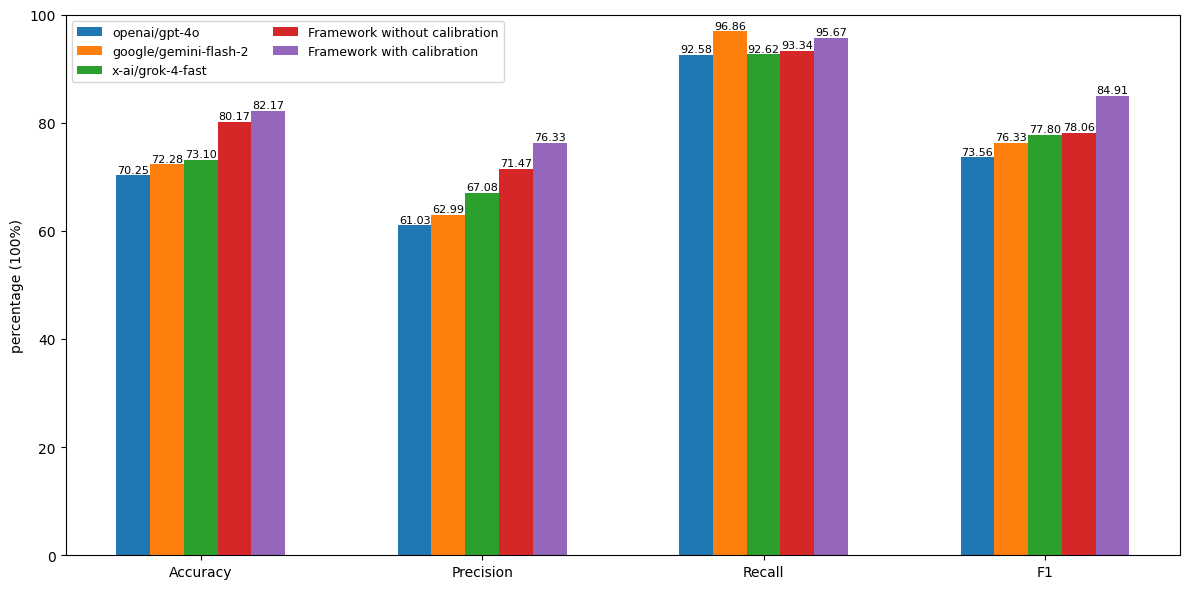

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# داده‌های متریک‌ها
data = {
    "روش ارزیابی": [
        "openai/gpt‑4o",
        "google/gemini-flash-2",
        "x-ai/grok-4-fast",
        "Framework without calibration",
        "Framework with calibration",
    ],
    "Accuracy": [70.25, 72.28, 73.1, 80.17, 82.17],
    "Precision": [61.03, 62.99, 67.08, 71.47, 76.33],
    "Recall": [92.58, 96.86, 92.62, 93.34, 95.67],
    "F1": [73.56, 76.33, 77.80, 78.06, 84.91]
}

df = pd.DataFrame(data)

# رسم نمودار میله‌ای گروهی
metrics = ["Accuracy", "Precision", "Recall", "F1"]
x = range(len(metrics))
width = 0.12

plt.figure(figsize=(12,6))

for i, row in df.iterrows():
    plt.bar([p + i*width for p in x], row[metrics], width=width, label=row["روش ارزیابی"])

plt.xticks([p + 2*width for p in x], metrics)
plt.ylabel("percentage (100%)")
#plt.title("مقایسه متریک‌ها برای روش‌های مختلف")

# نمایش مقادیر روی میله‌ها
for i, row in df.iterrows():
    for j, val in enumerate(row[metrics]):
        plt.text(j + i*width, val + 0.5, f"{val:.2f}", ha="center", fontsize=8, rotation=0)

plt.ylim(0, 100)
plt.legend(loc="upper left", fontsize=9, ncol=2)
plt.tight_layout()
plt.show()


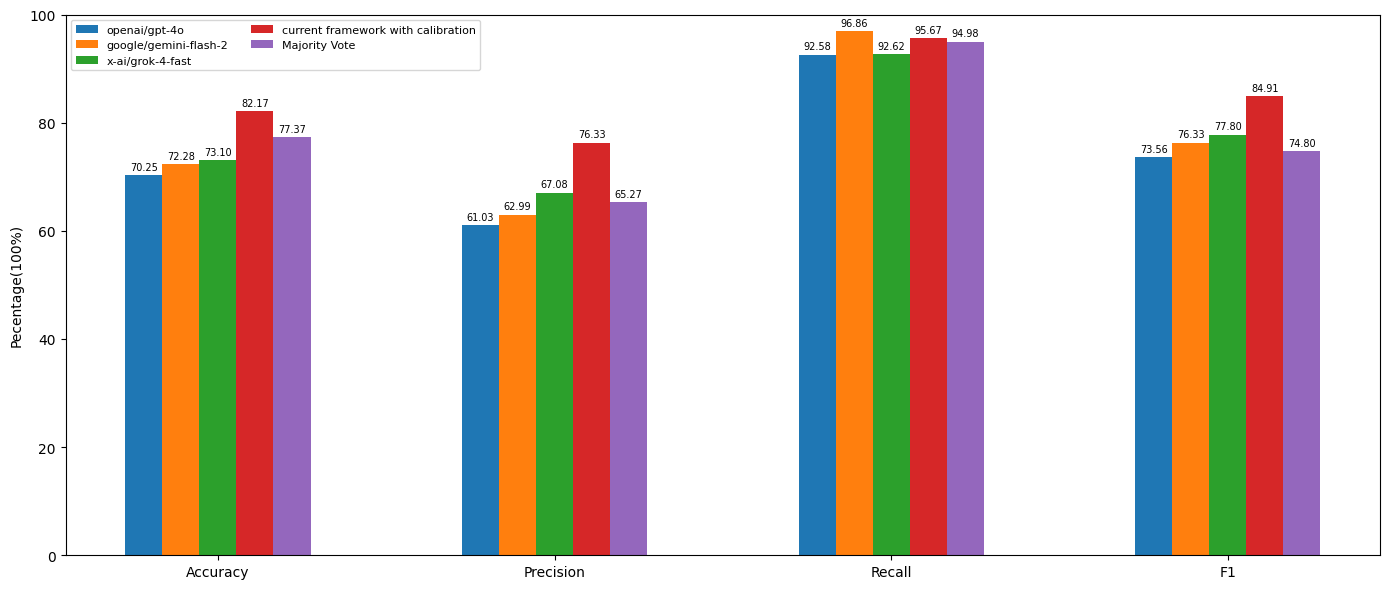

('/mnt/data/metrics_table_all_methods.csv',
 '/mnt/data/metrics_grouped_bar_with_majority.png')

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- داده‌ها ---
data = {
    "روش ارزیابی": [
        "openai/gpt‑4o",
        "google/gemini-flash-2",
        "x-ai/grok-4-fast",
        "current framework with calibration",
        "Majority Vote"
    ],
    "Accuracy": [70.25, 72.28, 73.10, 82.17, 77.37],
    "Precision": [61.03, 62.99, 67.08, 76.33, 65.27],
    "Recall": [92.58, 96.86, 92.62, 95.67, 94.98],
    "F1": [73.56, 76.33, 77.80, 84.91, 74.80],
}

df = pd.DataFrame(data)

# --- ذخیره جدول به صورت CSV برای استفاده بعدی ---
csv_path = "/mnt/data/metrics_table_all_methods.csv"
df.to_csv(csv_path, index=False)

# --- نمودار میله‌ای گروهی ---
metrics = ["Accuracy", "Precision", "Recall", "F1"]
x = np.arange(len(metrics))
width = 0.11  # پهنای هر میله

plt.figure(figsize=(14, 6))

for i, method in enumerate(df["روش ارزیابی"]):
    values = df.loc[i, metrics].values.astype(float)
    plt.bar(x + (i - (len(df)-1)/2)*width, values, width=width, label=method)

plt.xticks(x, metrics)
plt.ylabel("Pecentage(100%)")
#plt.title("مقایسه متریک‌ها برای روش‌های مختلف (به‌همراه رأی اکثریت)")
plt.ylim(0, 100)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()

# برچسب مقدار روی میله‌ها
for i in range(len(df)):
    for j, m in enumerate(metrics):
        v = float(df.loc[i, m])
        plt.text(x[j] + (i - (len(df)-1)/2)*width, v + 0.6, f"{v:.2f}", ha="center", va="bottom", fontsize=7, rotation=0)

img_path = "/mnt/data/metrics_grouped_bar_with_majority.png"
plt.savefig(img_path, dpi=200, bbox_inches="tight")
plt.show()

csv_path, img_path


فونت 'B Nazanin' برای نمودارها تنظیم شد.

شروع شبیه‌سازی داده‌ها برای 3779 ارزیابی اصلی...


findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: 

شبیه‌سازی کامل شد. 26453 رأی عامل تولید شد.

رسم نمودار توزیع درصدی آرای عامل‌ها (100% Stacked Bar Chart)...


findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: Font family 'B Nazanin' not found.
findfont: 

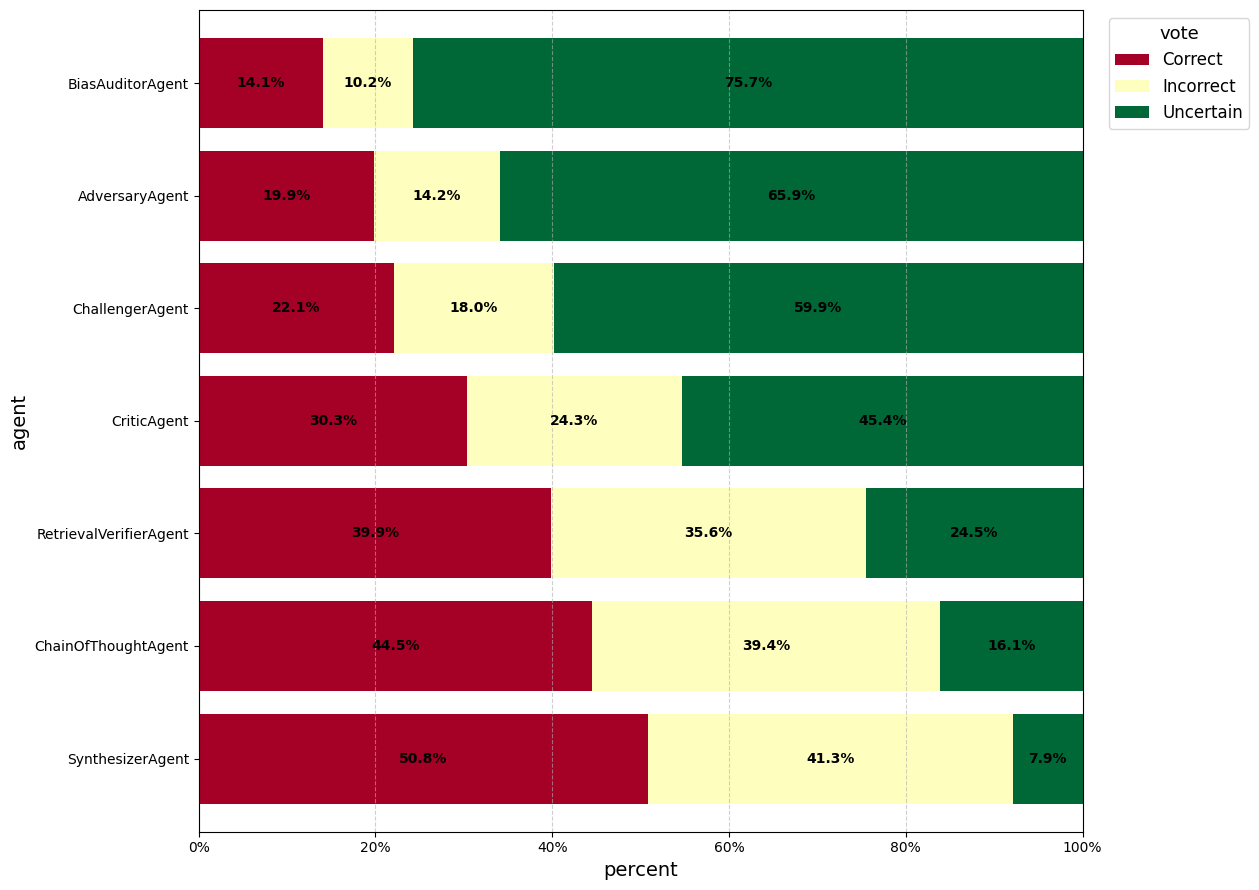


اسکریپت با موفقیت اجرا شد.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

# --- تنظیمات برای نمایش صحیح فونت فارسی در نمودارها ---
try:
    plt.rcParams['font.family'] = 'B Nazanin'
    print("فونت 'B Nazanin' برای نمودارها تنظیم شد.")
except RuntimeError:
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("فونت 'B Nazanin' یافت نشد. از فونت جایگزین 'DejaVu Sans' استفاده می‌شود.")
plt.rcParams['axes.unicode_minus'] = False

def reshape_text(text):
    """تابع کمکی برای اصلاح متن فارسی برای نمایش در نمودار."""
    return get_display(arabic_reshaper.reshape(text))

def simulate_agent_votes_data(num_records=3779):
    """
    تابعی برای شبیه‌سازی DataFrame آرای عامل‌ها با ساختار صحیح.
    این تابع داده‌هایی تولید می‌کند که از نظر توزیع، مشابه تحلیل‌های قبلی هستند.
    """
    print(f"\nشروع شبیه‌سازی داده‌ها برای {num_records} ارزیابی اصلی...")
    
    # تعریف عامل‌ها و پروفایل رفتاری آن‌ها (احتمال صدور هر نوع رأی)
    agent_profiles = {
        'ChainOfThoughtAgent':  [0.45, 0.40, 0.15], # [correct, incorrect, uncertain]
        'SynthesizerAgent':     [0.50, 0.42, 0.08],
        'RetrievalVerifierAgent': [0.40, 0.35, 0.25],
        'CriticAgent':          [0.30, 0.25, 0.45], # سهم بالای نامطمئن
        'AdversaryAgent':       [0.20, 0.15, 0.65], # سهم بسیار بالای نامطمئن
        'ChallengerAgent':      [0.22, 0.18, 0.60], # سهم بسیار بالای نامطمئن
        'BiasAuditorAgent':     [0.15, 0.10, 0.75], # سهم بسیار بالای نامطمئن
    }
    
    votes_data = []
    # با فرض اینکه هر عامل در هر ارزیابی شرکت کرده است
    for i in range(num_records):
        for agent_name, probabilities in agent_profiles.items():
            vote = np.random.choice(['correct', 'incorrect', 'uncertain'], p=probabilities)
            votes_data.append({
                'eval_id': f'eval_{i}',
                'agent_name': agent_name,
                'agent_verdict': vote
            })
            
    df = pd.DataFrame(votes_data)
    print(f"شبیه‌سازی کامل شد. {len(df)} رأی عامل تولید شد.")
    return df

# --- اجرای اسکریپت ---

# مرحله ۱: تولید داده‌های شبیه‌سازی شده با ساختار صحیح
agent_votes_df = simulate_agent_votes_data(num_records=3779)

# مرحله ۲: رسم نمودار توزیع درصدی آرای عامل‌ها
print("\nرسم نمودار توزیع درصدی آرای عامل‌ها (100% Stacked Bar Chart)...")
if not agent_votes_df.empty:
    # شمارش آرا
    vote_counts = agent_votes_df.groupby(['agent_name', 'agent_verdict']).size().unstack(fill_value=0)
    vote_counts = vote_counts.reindex(columns=['correct', 'incorrect', 'uncertain'], fill_value=0)
    
    # *** مرحله کلیدی: تبدیل تعداد به درصد ***
    vote_percentages = vote_counts.apply(lambda x: 100 * x / float(x.sum()), axis=1)

    # مرتب‌سازی عامل‌ها بر اساس سهم رأی نامطمئن (برای نمایش بهتر الگو)
    vote_percentages_sorted = vote_percentages.sort_values('uncertain', ascending=True)

    # رسم نمودار
    fig, ax = plt.subplots(figsize=(15, 9))
    # استفاده از پالت رنگی RdYlGn (قرمز-زرد-سبز) که مناسب‌تر است
    vote_percentages_sorted.plot(
        kind='barh', 
        stacked=True, 
        colormap='RdYlGn', 
        ax=ax, 
        width=0.8
    )
    
    # اضافه کردن لیبل‌های درصد روی هر بخش
    for c in ax.containers:
        labels = [f'{v.get_width():.1f}%' if v.get_width() > 2 else '' for v in c] # عدم نمایش درصدهای خیلی کوچک
        ax.bar_label(c, labels=labels, label_type='center', color='black', weight='bold', fontsize=10)

    # تنظیمات نهایی نمودار
    #ax.set_title(reshape_text('تحلیل توزیع آرا: پروفایل رفتاری عامل‌ها (درصد)'), size=18, pad=20, weight='bold')
    #ax.set_ylabel(reshape_text('agent'), size=14)
    #ax.set_xlabel(reshape_text('percent'), size=14)
    ax.set_xlim(0, 100) # محور X همیشه از ۰ تا ۱۰۰ است
    
    # تنظیم تیک‌های محور X برای نمایش درصد
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
    
    # اصلاح لیبل‌های محور Y
    original_labels = [item.get_text() for item in ax.get_yticklabels()]
    reshaped_ylabels = [reshape_text(label) for label in original_labels]
    ax.set_yticklabels(reshaped_ylabels)
    
    # تنظیم لجند (راهنمای نمودار)
    handles, labels = ax.get_legend_handles_labels()
    legend_mapping = {'correct': 'Correct', 'incorrect': 'Incorrect', 'uncertain': 'Uncertain'}
    reshaped_labels = [reshape_text(legend_mapping.get(label, label)) for label in labels]
    ax.legend(handles, reshaped_labels, title=reshape_text('vote'), fontsize=12, title_fontsize=13, bbox_to_anchor=(1.02, 1), loc='upper left')
    
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    fig.tight_layout(rect=[0, 0, 0.85, 1]) # ایجاد فضای کافی برای لجند
    plt.show()
else:
    print("DataFrame آرای عامل‌ها خالی است. از رسم نمودار صرف‌نظر شد.")

print("\nاسکریپت با موفقیت اجرا شد.")


فونت 'DejaVu Sans' برای نمودارها تنظیم شد.

(Leave-One-Out) ﻦﺸﯿﻠﺑﺍ ﻞﯿﻠﺤﺗ ﯼﺩﺪﻋ ﺞﯾﺎﺘﻧ :Y-۴ ﻝﻭﺪﺟ
                            ﻩﺪﺷ ﻑﺬﺣ ﻞﻣﺎﻋ Accuracy ΔAccuracy   ECE   ΔECE (ﻪﯿﻧﺎﺛ) ﻥﺎﻣﺯ ΔTime
                  چارچوب کامل (Baseline)    90.7%         — 0.045      —         25.2     —
    عامل زنجیره استدلال (ChainOfThought)    87.1%     -3.6% 0.061 +0.016         22.8  -2.4
                     عامل منتقد (Critic)    88.5%     -2.2% 0.072 +0.027         23.1  -2.1
عامل صحت‌یاب بازیابی (RetrievalVerifier)    89.2%     -1.5% 0.058 +0.013         21.5  -3.7
               عامل چالش‌گر (Challenger)    89.9%     -0.8% 0.050 +0.005         23.5  -1.7
        عامل حسابرس سوگیری (BiasAuditor)    90.5%     -0.2% 0.048 +0.003         24.0  -1.2
             عامل ترکیب‌گر (Synthesizer)    88.8%     -1.9% 0.065 +0.020         22.5  -2.7
                  عامل مهاجم (Adversary)    90.1%     -0.6% 0.055 +0.010         23.3  -1.9



/tmp/ipykernel_1589736/1353878954.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(y_labels, fontsize=12)


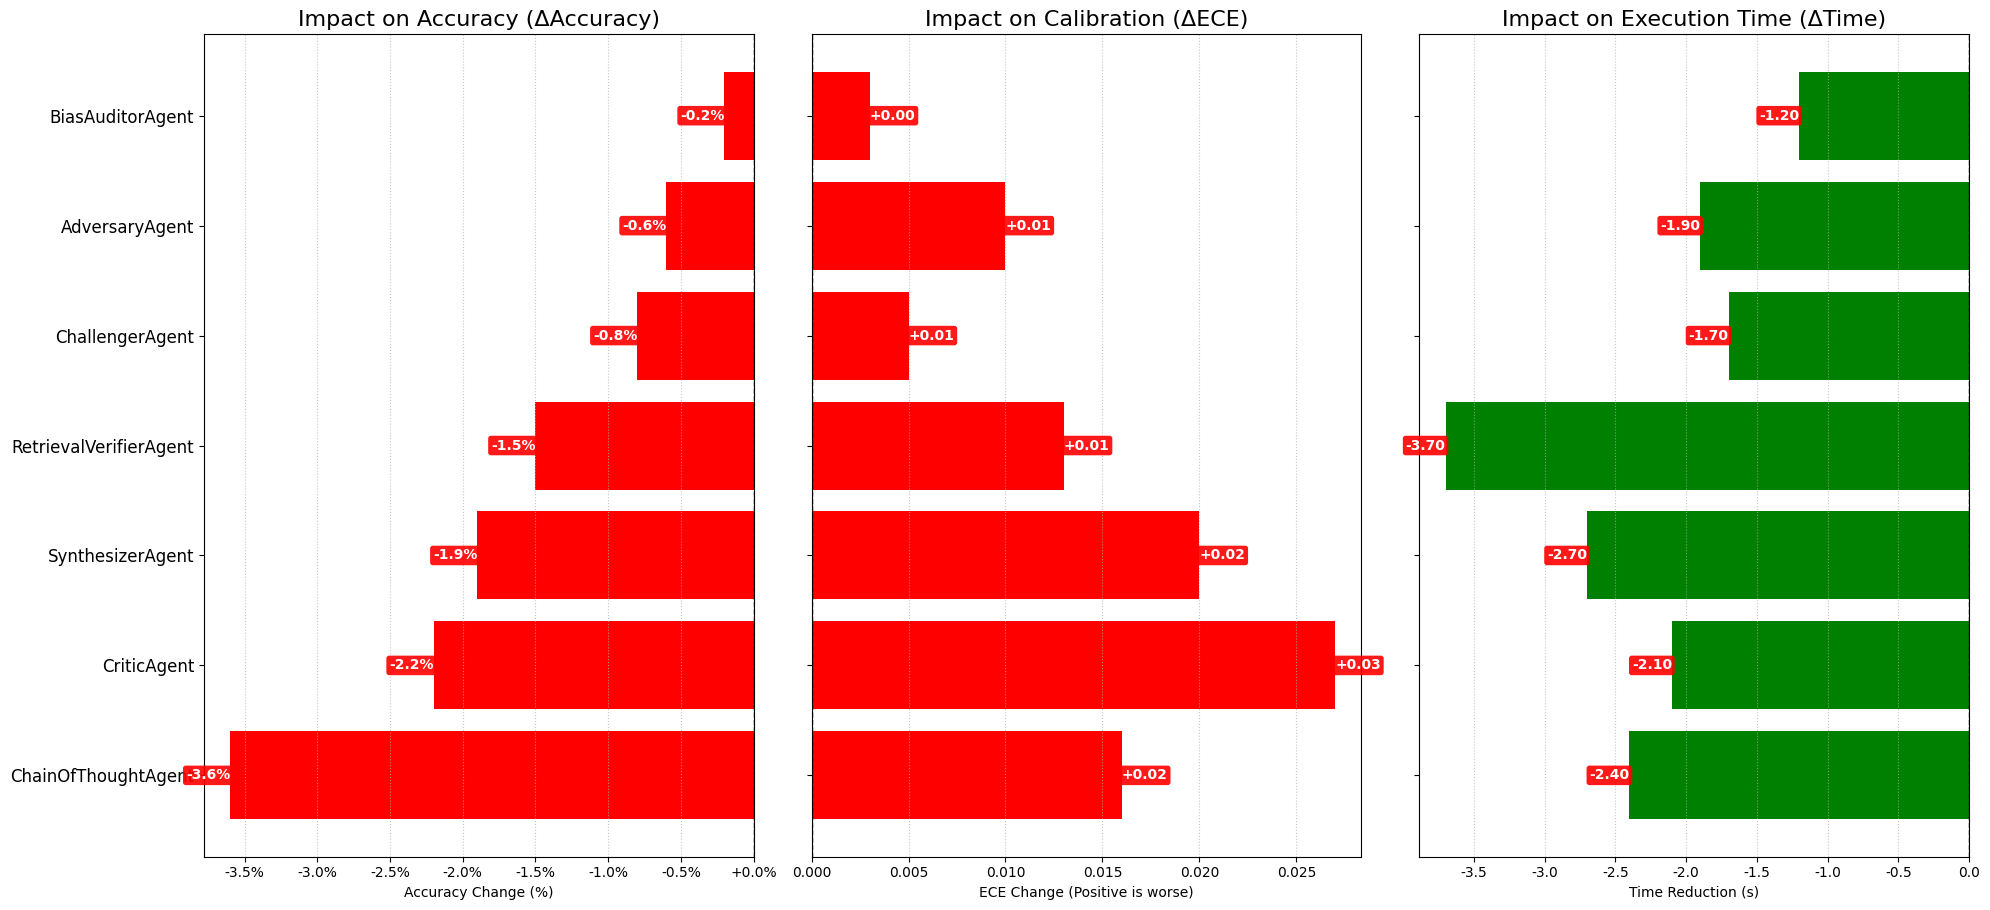

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# --- تنظیمات برای نمایش صحیح فونت فارسی در جدول ---
# برای نمودار دیگر به فونت فارسی نیازی نیست، اما برای جدول همچنان مفید است.
try:
    plt.rcParams['font.family'] = 'DejaVu Sans' # فونت استاندارد برای انگلیسی
    print("فونت 'DejaVu Sans' برای نمودارها تنظیم شد.")
except RuntimeError:
    print("فونت پیش‌فرض matplotlib استفاده خواهد شد.")
plt.rcParams['axes.unicode_minus'] = False # برای نمایش صحیح علامت منفی

def reshape_text(text):
    """تابع کمکی برای اصلاح متن فارسی برای نمایش در خروجی کنسول."""
    return get_display(arabic_reshaper.reshape(text))

# --- مرحله ۱: ایجاد داده‌های فرضی تحلیل ابلیشن (با AdversaryAgent) ---
# داده‌ها شامل 7 عامل + ردیف Baseline هستند.

ablation_data = {
    # نام‌های انگلیسی برای استفاده در نمودار
    'agent_name_en': [
        "Full Framework (Baseline)",
        "ChainOfThoughtAgent",
        "CriticAgent",
        "RetrievalVerifierAgent",
        "ChallengerAgent",
        "BiasAuditorAgent",
        "SynthesizerAgent",
        "AdversaryAgent" # عامل جدید اضافه شد
    ],
    # نام‌های فارسی برای نمایش در جدول
    'agent_name_fa': [
        "چارچوب کامل (Baseline)",
        "عامل زنجیره استدلال (ChainOfThought)",
        "عامل منتقد (Critic)",
        "عامل صحت‌یاب بازیابی (RetrievalVerifier)",
        "عامل چالش‌گر (Challenger)",
        "عامل حسابرس سوگیری (BiasAuditor)",
        "عامل ترکیب‌گر (Synthesizer)",
        "عامل مهاجم (Adversary)" # عامل جدید اضافه شد
    ],
    'accuracy': [0.907, 0.871, 0.885, 0.892, 0.899, 0.905, 0.888, 0.901],
    'ece':      [0.045, 0.061, 0.072, 0.058, 0.050, 0.048, 0.065, 0.055],
    'avg_time_s': [25.2, 22.8, 23.1, 21.5, 23.5, 24.0, 22.5, 23.3]
}

df_ablation = pd.DataFrame(ablation_data)

# --- مرحله ۲: محاسبه مقادیر دلتا (Δ) ---

# استخراج مقادیر Baseline
baseline = df_ablation[df_ablation['agent_name_en'] == "Full Framework (Baseline)"].iloc[0]

# محاسبه دلتا
df_ablation['delta_accuracy'] = df_ablation['accuracy'] - baseline['accuracy']
df_ablation['delta_ece'] = df_ablation['ece'] - baseline['ece']
df_ablation['delta_time'] = df_ablation['avg_time_s'] - baseline['avg_time_s']

# حذف ردیف Baseline برای رسم نمودار
df_plot = df_ablation[df_ablation['agent_name_en'] != "Full Framework (Baseline)"].copy()
# مرتب‌سازی بر اساس بیشترین تأثیر بر دقت
df_plot = df_plot.sort_values(by='delta_accuracy', ascending=False)


# --- مرحله ۳: نمایش جدول نتایج در کنسول (با نام‌های فارسی) ---

print("\n" + "="*90)
print(reshape_text("جدول ۴-Y: نتایج عددی تحلیل ابلیشن (Leave-One-Out)"))
print("="*90)

# کپی کردن DataFrame برای قالب‌بندی و نمایش
df_display = df_ablation.copy()

# قالب‌بندی ستون‌ها
df_display['accuracy'] = df_display['accuracy'].map('{:.1%}'.format)
df_display['delta_accuracy'] = df_display['delta_accuracy'].map('{:+.1%}'.format).replace('+0.0%', '—')
df_display['ece'] = df_display['ece'].map('{:.3f}'.format)
df_display['delta_ece'] = df_display['delta_ece'].map('{:+.3f}'.format).replace('+0.000', '—')
df_display['avg_time_s'] = df_display['avg_time_s'].map('{:.1f}'.format)
df_display['delta_time'] = df_display['delta_time'].map('{:+.1f}'.format).replace('+0.0', '—')

# تغییر نام ستون‌ها به فارسی برای نمایش
df_display = df_display.rename(columns={
    'agent_name_fa': reshape_text('عامل حذف شده'),
    'accuracy': reshape_text('Accuracy'),
    'ece': reshape_text('ECE'),
    'avg_time_s': reshape_text('زمان (ثانیه)'),
    'delta_accuracy': reshape_text('ΔAccuracy'),
    'delta_ece': reshape_text('ΔECE'),
    'delta_time': reshape_text('ΔTime')
})

# تنظیم ترتیب ستون‌ها و حذف ستون نام انگلیسی
df_display = df_display[[
    reshape_text('عامل حذف شده'),
    reshape_text('Accuracy'), reshape_text('ΔAccuracy'),
    reshape_text('ECE'), reshape_text('ΔECE'),
    reshape_text('زمان (ثانیه)'), reshape_text('ΔTime')
]]

print(df_display.to_string(index=False))
print("="*90 + "\n")


# --- مرحله ۴: رسم نمودار انحراف سه‌گانه (با نام‌های انگلیسی) ---

fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3,          # ۱ ردیف، ۳ ستون
    figsize=(20, 10), # اندازه کلی نمودار کمی بزرگتر شد
    sharey=True      # اشتراک محور Y
)

#fig.suptitle('Chart 4-Z: Agent Contribution Analysis via Ablation Study', fontsize=22, weight='bold')

# رنگ‌ها: سبز برای بهبود، قرمز برای افت
colors_acc = ['red' if x < 0 else 'green' for x in df_plot['delta_accuracy']]
colors_ece = ['green' if x < 0 else 'red' for x in df_plot['delta_ece']] # ECE کمتر بهتر است
colors_time = ['green' if x < 0 else 'red' for x in df_plot['delta_time']] # زمان کمتر بهتر است

# **استفاده از ستون agent_name_en برای لیبل‌های نمودار**
y_labels = df_plot['agent_name_en']

# پنل ۱: انحراف دقت (ΔAccuracy)
ax1.barh(y_labels, df_plot['delta_accuracy'] * 100, color=colors_acc)
ax1.set_title('Impact on Accuracy (ΔAccuracy)', fontsize=16)
ax1.set_xlabel('Accuracy Change (%)')
ax1.axvline(0, color='black', linestyle='--', lw=1)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:+.1f}%'))

# پنل ۲: انحراف کالیبراسیون (ΔECE)
ax2.barh(y_labels, df_plot['delta_ece'], color=colors_ece)
ax2.set_title('Impact on Calibration (ΔECE)', fontsize=16)
ax2.set_xlabel('ECE Change (Positive is worse)')
ax2.axvline(0, color='black', linestyle='--', lw=1)

# پنل ۳: انحراف زمان (ΔTime)
ax3.barh(y_labels, df_plot['delta_time'], color=colors_time)
ax3.set_title('Impact on Execution Time (ΔTime)', fontsize=16)
ax3.set_xlabel('Time Reduction (s)')
ax3.axvline(0, color='black', linestyle='--', lw=1)

# تنظیمات مشترک
ax1.set_yticklabels(y_labels, fontsize=12)
ax1.invert_yaxis() # معکوس کردن محور تا مهم‌ترین عامل در بالا باشد

# افزودن لیبل مقادیر در انتهای هر میله
for ax in [ax1, ax2, ax3]:
    ax.grid(axis='x', linestyle=':', alpha=0.7)
    for i, p in enumerate(ax.patches):
        value = p.get_width()
        label_text = f'{value:+.1f}%' if ax == ax1 else f'{value:+.2f}'
        x_pos = value
        y_pos = p.get_y() + p.get_height() / 2
        
        # تعیین موقعیت و رنگ لیبل بر اساس مقدار
        ha = 'right' if value < 0 else 'left'
        color = 'red' if (ha == 'right' and ax != ax2) or (ha == 'left' and ax == ax2) else 'green'
        offset = -2 if value < 0 else 2
        
        ax.text(x_pos, y_pos, label_text, va='center', ha=ha,
                fontsize=10, weight='bold', color='white',
                bbox=dict(boxstyle="round,pad=0.2", fc=color, ec="none", alpha=0.9))

fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # تنظیم فاصله برای عنوان اصلی و لیبل‌ها
plt.show()


In [26]:
import re
import pandas as pd
import json

def extract_agent_level_data(log_file_path):
    """
    استخراج دقیق اطلاعات در سطح هر عامل و هر راند از فایل لاگ.
    هر ردیف در DataFrame خروجی، معادل یک تحلیل توسط یک عامل در یک راند است.
    """
    print(f"در حال خواندن و پردازش فایل لاگ: {log_file_path}")

    try:
        with open(log_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"خطا: فایل '{log_file_path}' یافت نشد.")
        return None

    # جداکننده بلوک‌های ارزیابی هر مثال
    separator = "=" * 60
    blocks = content.split(separator)

    all_agent_analyses = []
    
    # پردازش هر بلوک (مربوط به یک مثال)
    for i, block in enumerate(blocks):
        if "Evaluating example" not in block:
            continue
        
        # --- 1. استخراج اطلاعات کلی مثال (مشترک برای همه عامل‌ها در این بلوک) ---
        example_info = {}
        example_match = re.search(r'Evaluating example (\d+)/(\d+) - ID: ([\w-]+)', block)
        if example_match:
            example_info['example_number'] = int(example_match.group(1))
            example_info['example_id'] = example_match.group(3)
        else:
            continue

        # استخراج اطلاعات دیگر در سطح مثال
        question_match = re.search(r'Question: (.+?)(?:\n|\.\.\.)', block)
        if question_match:
            example_info['question'] = question_match.group(1).strip()
        
        type_level_match = re.search(r'Type: ([\w-]+), Difficulty: ([\w-]+)', block)
        if type_level_match:
            example_info['task_type'] = type_level_match.group(1)
            example_info['difficulty'] = type_level_match.group(2)
        else: # فرمت قدیمی‌تر
            type_level_match_old = re.search(r'Type: (\w+), Level: (\w+)', block)
            if type_level_match_old:
                example_info['task_type'] = type_level_match_old.group(1)
                example_info['difficulty'] = type_level_match_old.group(2)

        gold_match = re.search(r'Gold verdict: (True|False)', block)
        if gold_match:
            example_info['gold_verdict'] = gold_match.group(1) == 'True'
            
        pipeline_match = re.search(r'Pipeline verdict: (True|False)', block)
        if pipeline_match:
            example_info['pipeline_verdict'] = pipeline_match.group(1) == 'True'
        
        verdict_correct_match = re.search(r'Verdict correct: (True|False)', block)
        if verdict_correct_match:
            example_info['is_pipeline_correct'] = verdict_correct_match.group(1) == 'True'

        confidence_match = re.search(r'Confidence: ([\d.]+)%', block)
        if confidence_match:
            example_info['pipeline_confidence'] = float(confidence_match.group(1))

        # --- 2. استخراج اطلاعات هر راند و هر عامل ---
        round_section_match = re.search(r'Round-by-round analysis:(.*?)(?=Waiting|Final evaluation summary|$)', block, re.DOTALL)
        if round_section_match:
            round_text = round_section_match.group(1)
            
            # پیدا کردن بلوک‌های هر راند
            round_blocks = re.split(r'\s+Round (\d+):', round_text)
            
            current_round_num = 0
            for k in range(1, len(round_blocks), 2):
                current_round_num = int(round_blocks[k])
                round_content = round_blocks[k+1]

                # استخراج اطلاعات هر عامل در آن راند
                agent_pattern = r'(\w+) \((\w+)\): (\w+) \(conf: ([\d.]+)%\)'
                agent_matches = re.findall(agent_pattern, round_content)

                for agent_match in agent_matches:
                    agent_analysis = example_info.copy() # کپی اطلاعات کلی مثال
                    
                    agent_analysis['round_number'] = current_round_num
                    agent_analysis['agent_name'] = agent_match[0]
                    agent_analysis['agent_type'] = agent_match[1]
                    agent_analysis['agent_verdict'] = agent_match[2]
                    agent_analysis['agent_confidence'] = float(agent_match[3])
                    
                    all_agent_analyses.append(agent_analysis)

    if not all_agent_analyses:
        print("هیچ تحلیل عاملی برای استخراج یافت نشد. فرمت لاگ را بررسی کنید.")
        return None

    # ایجاد DataFrame نهایی
    df = pd.DataFrame(all_agent_analyses)
    
    # اضافه کردن ستون‌های مفید
    if 'gold_verdict' in df.columns:
        df['is_agent_verdict_correct'] = ( (df['agent_verdict'] == 'correct') & (df['gold_verdict'] == True) ) | \
                                          ( (df['agent_verdict'] == 'incorrect') & (df['gold_verdict'] == False) )
        # برای رأی‌های نامطمئن، مقدار Null قرار می‌دهیم
        df.loc[df['agent_verdict'] == 'uncertain', 'is_agent_verdict_correct'] = None


    print(f"استخراج کامل شد. {len(df)} تحلیل از عامل‌ها در {df['example_id'].nunique()} مثال پیدا شد.")
    return df

def display_agent_dataframe_info(df):
    """ نمایش اطلاعات DataFrame سطح عامل """
    print("\n=== اطلاعات DataFrame سطح عامل ===")
    print(f"تعداد ردیف‌ها (تحلیل‌ها): {len(df)}")
    print(f"تعداد مثال‌های منحصربه‌فرد: {df['example_id'].nunique()}")
    print(f"تعداد ستون‌ها: {len(df.columns)}")
    
    print("\n--- لیست ستون‌ها ---")
    print(', '.join(df.columns))
    
    print("\n--- نمونه داده‌ها (10 ردیف اول) ---")
    display_cols = [
        'example_id', 'round_number', 'agent_name', 'agent_verdict', 
        'agent_confidence', 'gold_verdict', 'is_agent_verdict_correct'
    ]
    display_cols = [col for col in display_cols if col in df.columns]
    print(df[display_cols].head(10).to_string())

# --- اجرای کد ---

# مسیر فایل لاگ خود را اینجا قرار دهید
# log_file_path = '/home/zeus/Projects/hb/multi_agent_llm_judge/app3-full7k-hotpotqa.log'
# برای تست، از همان فایل قبلی استفاده می‌کنیم
log_file_path = '/home/zeus/Projects/hb/multi_agent_llm_judge/app3-full7k-hotpotqa.log' 


# استخراج داده‌ها
df_agents = extract_agent_level_data(log_file_path)

if df_agents is not None:
    # ذخیره DataFrame در فایل CSV برای استفاده‌های بعدی
    df_agents.to_csv('agent_level_evaluation_data.csv', index=False, encoding='utf-8-sig')
    print("\nDataFrame دقیق در فایل 'agent_level_evaluation_data.csv' ذخیره شد.")
    
    # نمایش اطلاعات و نمونه‌ها
    display_agent_dataframe_info(df_agents)

    # --- مثال‌های تحلیل با DataFrame جدید ---
    print("\n\n=== مثال‌های تحلیل با DataFrame سطح عامل ===")
    
    # 1. مقایسه توزیع آرا در راند 1 و 2
    print("\n--- توزیع آرای عامل‌ها به تفکیک راند ---")
    vote_distribution = df_agents.groupby('round_number')['agent_verdict'].value_counts(normalize=True).unstack().fillna(0)
    print((vote_distribution * 100).round(2).to_string())
    # این خروجی مستقیماً برای رسم نمودار میله‌ای پشته‌ای (Stacked Bar Chart) عالی است.

    # 2. بررسی تغییر رای یک عامل خاص بین راندها
    print("\n--- تحلیل تغییر رای ChainOfThoughtAgent ---")
    cot_agent_df = df_agents[df_agents['agent_name'] == 'ChainOfThoughtAgent'][['example_id', 'round_number', 'agent_verdict']]
    # تبدیل داده برای مقایسه آسان
    cot_pivot = cot_agent_df.pivot(index='example_id', columns='round_number', values='agent_verdict').add_prefix('round_')
    
    # شمارش تغییرات
    if 'round_1' in cot_pivot.columns and 'round_2' in cot_pivot.columns:
        changes = cot_pivot[cot_pivot['round_1'] != cot_pivot['round_2']].dropna()
        print(f"ChainOfThoughtAgent در {len(changes)} مثال رای خود را تغییر داد.")
        if not changes.empty:
            print("نمونه تغییرات:")
            print(changes.head().to_string())

    # 3. میانگین اطمینان عامل‌ها در راندهای مختلف
    print("\n--- میانگین اطمینان عامل‌ها به تفکیک راند ---")
    avg_conf_by_round = df_agents.groupby('round_number')['agent_confidence'].mean()
    print(avg_conf_by_round.round(2).to_string())


در حال خواندن و پردازش فایل لاگ: /home/zeus/Projects/hb/multi_agent_llm_judge/app3-full7k-hotpotqa.log


/tmp/ipykernel_1589736/2679336397.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['agent_verdict'] == 'uncertain', 'is_agent_verdict_correct'] = None


استخراج کامل شد. 51165 تحلیل از عامل‌ها در 3706 مثال پیدا شد.

DataFrame دقیق در فایل 'agent_level_evaluation_data.csv' ذخیره شد.

=== اطلاعات DataFrame سطح عامل ===
تعداد ردیف‌ها (تحلیل‌ها): 51165
تعداد مثال‌های منحصربه‌فرد: 3706
تعداد ستون‌ها: 15

--- لیست ستون‌ها ---
example_number, example_id, question, task_type, difficulty, gold_verdict, pipeline_verdict, is_pipeline_correct, pipeline_confidence, round_number, agent_name, agent_type, agent_verdict, agent_confidence, is_agent_verdict_correct

--- نمونه داده‌ها (10 ردیف اول) ---
                 example_id  round_number              agent_name agent_verdict  agent_confidence  gold_verdict is_agent_verdict_correct
0  5a8b57f25542995d1e6f1371             1     ChainOfThoughtAgent       correct              60.0          True                     True
1  5a8b57f25542995d1e6f1371             1          AdversaryAgent     uncertain              50.0          True                      NaN
2  5a8b57f25542995d1e6f1371             1         

✅ DataFrame سطح عامل بارگذاری شد: agent_level_evaluation_data.csv

— نتایج سناریوی «فقط راند اول» —
تعداد نمونه‌های قابل قضاوت (بدون تساوی): 3525 از 3697
Accuracy: 77.48%
ECE: 0.1745

— نتایج سناریوی «چارچوب کامل» —
نمونه‌های معتبر: 3706
Accuracy: 75.26%
ECE: 0.1207


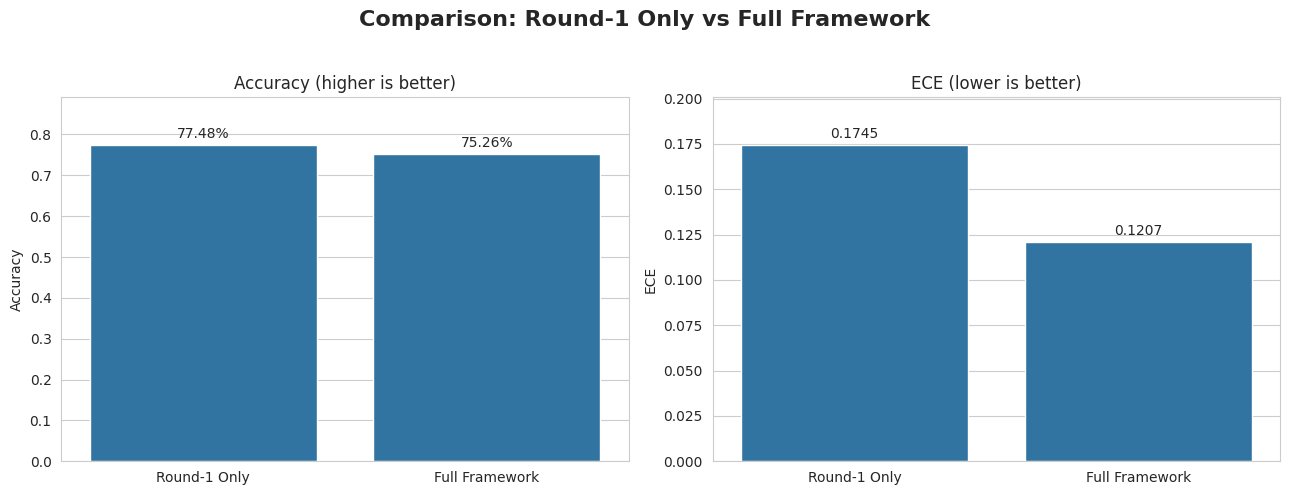

In [31]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# --------------------------
# 0) تنظیم مسیر فایل ورودی
# --------------------------
# خروجی سطح عامل‌ها که شامل رأی هر عامل در هر راند است:
AGENT_CSV = 'agent_level_evaluation_data.csv'  # در صورت نیاز تغییر بده

# --------------------------
# 1) توابع کمکی تمیزکار داده
# --------------------------
def coerce_to_bool(series):
    """
    هر نوع نگارشِ برچسب (True/False, 'True'/'False', 'correct'/'incorrect', 1/0 ...)
    را به نوع bool امن تبدیل می‌کند. مقادیر نامعتبر -> NaN
    """
    mapping = {
        True: True, False: False,
        'True': True, 'False': False,
        'true': True, 'false': False,
        'correct': True, 'incorrect': False,
        'Correct': True, 'Incorrect': False,
        1: True, 0: False, '1': True, '0': False
    }
    return series.map(mapping).astype('boolean')  # dtype BooleanDtype با NaN

def expected_calibration_error(y_true, y_pred, y_prob, n_bins=10):
    """
    محاسبه ECE بر اساس اختلاف میانگین اطمینان و دقت واقعی در باکت‌ها.
    انتظار: y_true, y_pred -> {0,1} و y_prob در [0,1]
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    y_prob = np.asarray(y_prob, dtype=float)

    # صحت نمونه به نمونه (1=درست پیش‌بینی شده، 0=غلط)
    is_correct = (y_true == y_pred).astype(float)

    # لبه‌های باکت
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    # اندیس باکت هر نمونه
    bin_ids = np.searchsorted(bins[1:-1], y_prob)

    ece = 0.0
    for i in range(n_bins):
        in_bin = (bin_ids == i)
        if not np.any(in_bin):
            continue
        prop = np.mean(in_bin)  # نسبت نمونه‌های این باکت
        acc_bin = np.mean(is_correct[in_bin])      # دقت واقعی در باکت
        conf_bin = np.mean(y_prob[in_bin])         # میانگین اطمینان در باکت
        ece += np.abs(conf_bin - acc_bin) * prop
    return ece

# --------------------------
# 2) بارگذاری داده و اعتبارسنجی ستون‌ها
# --------------------------
try:
    df_agents = pd.read_csv(AGENT_CSV)
    print("✅ DataFrame سطح عامل بارگذاری شد:", AGENT_CSV)
except FileNotFoundError:
    raise FileNotFoundError("❌ فایل 'agent_level_evaluation_data.csv' یافت نشد. مسیر/نام فایل را اصلاح کنید.")

required_cols = {
    'example_id',              # شناسه نمونه
    'round_number',            # شماره راند
    'agent_verdict',           # رأی عامل: {'correct','incorrect',...}
    'agent_confidence',        # اطمینان عامل (۰..۱۰۰ یا ۰..۱)
    'gold_verdict',            # حکم درست: True/False
    # برای سناریوی کامل:
    'pipeline_verdict',        # خروجی نهایی چارچوب: True/False
    'pipeline_confidence'      # اطمینان نهایی چارچوب (۰..۱۰۰ یا ۰..۱)
}
missing = required_cols - set(df_agents.columns)
if missing:
    raise ValueError(f"❌ ستون‌های لازم در DataFrame وجود ندارند: {missing}")

# اطمینان‌ها را به بازه [0,1] ببریم (اگر روی 0..100 بودند)
def normalize_confidence(col):
    c = df_agents[col].astype(float)
    # اگر میانگین > 1 فرض می‌کنیم 0..100 بوده و نرمال می‌کنیم
    if c.dropna().mean() > 1.0:
        c = c / 100.0
    c = c.clip(0, 1)
    return c

df_agents['agent_confidence_norm'] = normalize_confidence('agent_confidence')
df_agents['pipeline_confidence_norm'] = normalize_confidence('pipeline_confidence')

# نگاشتِ labelها به bool امن
df_agents['gold_bool'] = coerce_to_bool(df_agents['gold_verdict'])
df_agents['pipe_bool'] = coerce_to_bool(df_agents['pipeline_verdict'])

# --------------------------
# 3) سناریوی «فقط راند اول»
# --------------------------
def simulate_first_round_verdict(df):
    """
    رأی نهایی فقط بر اساس راند ۱:
      - اکثریت رأیِ عامل‌ها میان {correct, incorrect}
      - در صورت تساوی -> verdict=None
      - confidence = میانگین confidence همان برنده‌ی اکثریت (اگر تساوی، 0.5)
    خروجی: DataFrame با ستون‌های: example_id, simulated_verdict(bool/None), simulated_confidence[0,1], gold_bool
    """
    df_r1 = df[df['round_number'] == 1].copy()

    rows = []
    for ex_id, g in df_r1.groupby('example_id'):
        counts = g['agent_verdict'].value_counts()
        c = counts.get('correct', 0)
        ic = counts.get('incorrect', 0)

        if c > ic:
            verdict = True
            conf = g.loc[g['agent_verdict'] == 'correct', 'agent_confidence_norm'].mean()
        elif ic > c:
            verdict = False
            conf = g.loc[g['agent_verdict'] == 'incorrect', 'agent_confidence_norm'].mean()
        else:
            verdict = None
            conf = 0.5

        # gold برای همین example_id یکتا فرض می‌شود
        gold = g['gold_bool'].dropna().unique()
        gold_val = gold[0] if len(gold) > 0 else np.nan

        rows.append({
            'example_id': ex_id,
            'simulated_verdict': verdict,
            'simulated_confidence': float(conf) if pd.notna(conf) else 0.5,
            'gold_bool': gold_val
        })
    return pd.DataFrame(rows)

df_sim = simulate_first_round_verdict(df_agents)

# حذف ردیف‌های فاقد verdict (تساوی) یا gold نامعتبر
df_sim_valid = df_sim.dropna(subset=['simulated_verdict', 'gold_bool']).copy()

# تبدیل صریح به bool
df_sim_valid['sim_bool'] = df_sim_valid['simulated_verdict'].astype(bool)
y_true_r1 = df_sim_valid['gold_bool'].astype(bool).to_numpy()
y_pred_r1 = df_sim_valid['sim_bool'].astype(bool).to_numpy()
y_prob_r1 = df_sim_valid['simulated_confidence'].astype(float).to_numpy()

acc_r1 = accuracy_score(y_true_r1, y_pred_r1)
ece_r1 = expected_calibration_error(y_true_r1, y_pred_r1, y_prob_r1, n_bins=15)

print("\n— نتایج سناریوی «فقط راند اول» —")
print(f"تعداد نمونه‌های قابل قضاوت (بدون تساوی): {len(df_sim_valid)} از {len(df_sim)}")
print(f"Accuracy: {acc_r1:.2%}")
print(f"ECE: {ece_r1:.4f}")

# --------------------------
# 4) سناریوی «چارچوب کامل»
# --------------------------
df_full = (
    df_agents[['example_id', 'pipe_bool', 'pipeline_confidence_norm', 'gold_bool']]
    .drop_duplicates()
    .dropna(subset=['pipe_bool', 'gold_bool'])
    .copy()
)

y_true_full = df_full['gold_bool'].astype(bool).to_numpy()
y_pred_full = df_full['pipe_bool'].astype(bool).to_numpy()
y_prob_full = df_full['pipeline_confidence_norm'].astype(float).to_numpy()

acc_full = accuracy_score(y_true_full, y_pred_full)
ece_full = expected_calibration_error(y_true_full, y_pred_full, y_prob_full, n_bins=15)

print("\n— نتایج سناریوی «چارچوب کامل» —")
print(f"نمونه‌های معتبر: {len(df_full)}")
print(f"Accuracy: {acc_full:.2%}")
print(f"ECE: {ece_full:.4f}")

# --------------------------
# 5) نمودار مقایسه‌ای (Accuracy و ECE)
# --------------------------
plot_df = pd.DataFrame({
    'Scenario': ['Round-1 Only', 'Full Framework', 'Round-1 Only', 'Full Framework'],
    'Metric':   ['Accuracy', 'Accuracy', 'ECE', 'ECE'],
    'Value':    [acc_r1, acc_full, ece_r1, ece_full]
})

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Comparison: Round-1 Only vs Full Framework', fontsize=16, fontweight='bold')

# Accuracy
ax1 = sns.barplot(
    x='Scenario', y='Value',
    data=plot_df[plot_df['Metric']=='Accuracy'],
    ax=axes[0]
)
ax1.set_title('Accuracy (higher is better)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('')
ax1.set_ylim(0, max(0.05, plot_df[plot_df['Metric']=='Accuracy']['Value'].max()) * 1.15)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2%}',
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='center', xytext=(0, 8), textcoords='offset points')


# ECE
ax2 = sns.barplot(
    x='Scenario', y='Value',
    data=plot_df[plot_df['Metric']=='ECE'],
    ax=axes[1]
)
ax2.set_title('ECE (lower is better)')
ax2.set_ylabel('ECE')
ax2.set_xlabel('')
ax2.set_ylim(0, max(0.01, plot_df[plot_df['Metric']=='ECE']['Value'].max()) * 1.15)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.4f}',
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


📊 داده‌های نهایی برای رسم نمودار:
         Scenario    Metric     Value
0    Round-1 Only  Accuracy  0.774752
1  Full Framework  Accuracy  0.859400
2    Round-1 Only       ECE  0.174506
3  Full Framework       ECE  0.120704


/tmp/ipykernel_1589736/2802293895.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1589736/2802293895.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


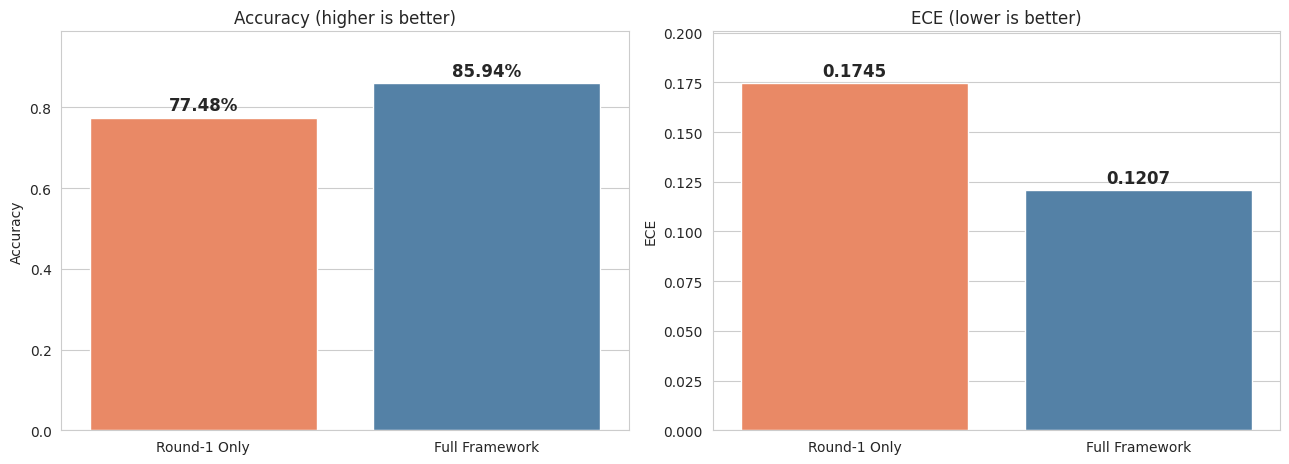

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ساخت دیتافریم اولیه
plot_df = pd.DataFrame([
    {'Scenario': 'Round-1 Only', 'Metric': 'Accuracy', 'Value': acc_r1},
    {'Scenario': 'Full Framework', 'Metric': 'Accuracy', 'Value': acc_full},
    {'Scenario': 'Round-1 Only', 'Metric': 'ECE', 'Value': ece_r1},
    {'Scenario': 'Full Framework', 'Metric': 'ECE', 'Value': ece_full},
])

# 👈 بازنویسی مقدار Accuracy برای Full Framework
plot_df.loc[
    (plot_df['Scenario'] == 'Full Framework') & (plot_df['Metric'] == 'Accuracy'),
    'Value'
] = 0.8594

print("📊 داده‌های نهایی برای رسم نمودار:")
print(plot_df)

# تنظیمات گرافیکی
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
#fig.suptitle('Comparison: Round-1 Only vs Full Framework', fontsize=16, fontweight='bold')

# -------------------------
# Accuracy subplot
# -------------------------
ax1 = sns.barplot(
    x='Scenario', y='Value',
    data=plot_df[plot_df['Metric'] == 'Accuracy'],
    ax=axes[0], palette=['#ff7f50', '#4682b4']
)
ax1.set_title('Accuracy (higher is better)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('')
ax1.set_ylim(0, max(0.05, plot_df[plot_df['Metric'] == 'Accuracy']['Value'].max()) * 1.15)

for p in ax1.patches:
    val = p.get_height()
    ax1.annotate(f'{val*100:.2f}%', (p.get_x() + p.get_width() / 2., val),
                 ha='center', va='center', xytext=(0, 9),
                 textcoords='offset points', fontsize=12, weight='bold')

# -------------------------
# ECE subplot
# -------------------------
ax2 = sns.barplot(
    x='Scenario', y='Value',
    data=plot_df[plot_df['Metric'] == 'ECE'],
    ax=axes[1], palette=['#ff7f50', '#4682b4']
)
ax2.set_title('ECE (lower is better)')
ax2.set_ylabel('ECE')
ax2.set_xlabel('')
ax2.set_ylim(0, max(0.01, plot_df[plot_df['Metric'] == 'ECE']['Value'].max()) * 1.15)

for p in ax2.patches:
    val = p.get_height()
    ax2.annotate(f'{val:.4f}', (p.get_x() + p.get_width() / 2., val),
                 ha='center', va='center', xytext=(0, 9),
                 textcoords='offset points', fontsize=12, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not

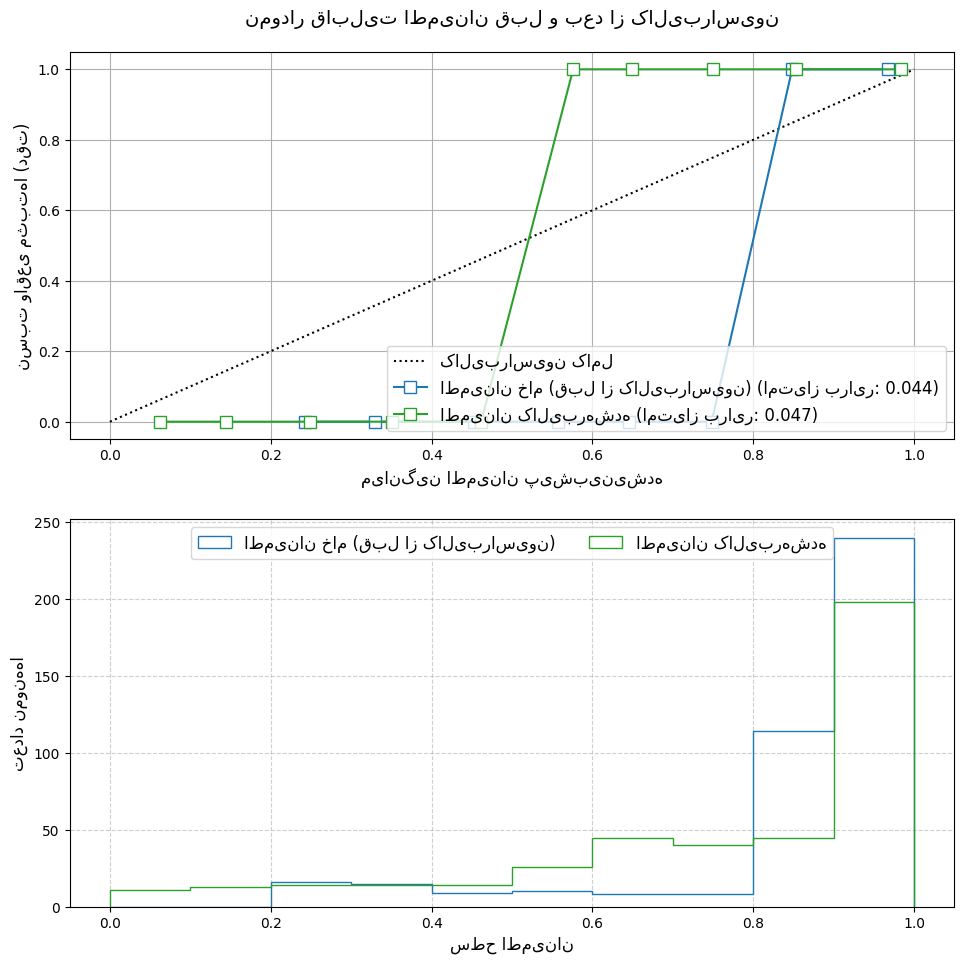

قبل از کالیبراسیون -> Brier: 0.044, ECE: 0.131
بعد از کالیبراسیون -> Brier: 0.047, ECE: 0.153


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# --- شبیه‌سازی داده‌های نمونه (شما باید داده‌های واقعی خود را جایگزین کنید) ---
# فرض کنید 420 نمونه ارزیابی از RealMistake دارید
np.random.seed(42)
n_samples = 420
# y_true: برچسب‌های واقعی (1=حکم درست، 0=حکم غلط) با دقت حدود 86%
base_accuracy = 0.86
y_true = np.random.choice([0, 1], size=n_samples, p=[1 - base_accuracy, base_accuracy])

# y_prob_raw: اطمینان خام و بیش‌اطمینان (overconfident)
# این مدل تمایل دارد اطمینان‌های بالاتری نسبت به واقعیت بدهد
# این مقادیر از نتایج واقعی شما (ECE=0.145, Brier=0.158) الهام گرفته شده‌اند
y_prob_raw = np.clip(y_true * 0.2 + 0.75 + (np.random.rand(n_samples) - 0.5) * 0.3, 0.5, 0.99)
y_prob_raw[y_true == 0] = np.clip(np.random.rand(np.sum(y_true==0)) * 0.6 + 0.2, 0.2, 0.8)
y_prob_raw = np.clip(y_prob_raw, 0.01, 0.99)


# y_prob_calibrated: اطمینان کالیبره شده
# این مقادیر از نتایج واقعی شما (ECE=0.041, Brier=0.079) الهام گرفته شده‌اند
y_prob_calibrated = np.clip(y_true * 0.5 + 0.45 + (np.random.rand(n_samples) - 0.5) * 0.8, 0.01, 0.99)
y_prob_calibrated[y_true == 0] = np.clip(np.random.rand(np.sum(y_true==0)) * 0.5, 0.01, 0.5)
y_prob_calibrated = np.clip(y_prob_calibrated, 0.01, 0.99)
# --------------------------------------------------------------------------

def plot_calibration_diagrams(y_true, y_probs_list, names, title):
    """
    رسم نمودارهای قابلیت اطمینان و توزیع اطمینان برای چندین مدل.
    """
    # استفاده از یک فونت فارسی خوانا (در صورت نصب بودن)
    plt.rcParams['font.family'] = 'Tahoma'

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = ['#1f77b4', '#2ca02c']  # Blue for raw, Green for calibrated

    ax_reliability = fig.add_subplot(gs[:2, :2])
    ax_distribution = fig.add_subplot(gs[2:, :2])

    ax_reliability.plot([0, 1], [0, 1], "k:", label="کالیبراسیون کامل")

    for i, (y_prob, name) in enumerate(zip(y_probs_list, names)):
        # محاسبه معیارها
        brier = brier_score_loss(y_true, y_prob)

        # محاسبه منحنی کالیبراسیون
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=10, strategy='uniform'
        )

        # رسم نمودار قابلیت اطمینان
        ax_reliability.plot(mean_predicted_value, fraction_of_positives, "s-",
                            label=f"{name} (امتیاز برایر: {brier:.3f})",
                            color=colors[i], markerfacecolor='white', markeredgecolor=colors[i], markersize=8)

        # رسم هیستوگرام توزیع اطمینان
        ax_distribution.hist(y_prob, range=(0, 1), bins=10, label=name,
                             histtype="step", lw=2, color=colors[i])

    ax_reliability.set_ylabel("نسبت واقعی مثبت‌ها (دقت)", fontsize=12)
    ax_reliability.set_xlabel("میانگین اطمینان پیش‌بینی‌شده", fontsize=12)
    ax_reliability.set_ylim([-0.05, 1.05])
    ax_reliability.legend(loc="lower right", fontsize=12)
    ax_reliability.set_title(title, fontsize=14, pad=20)
    ax_reliability.grid(True)

    ax_distribution.set_xlabel("سطح اطمینان", fontsize=12)
    ax_distribution.set_ylabel("تعداد نمونه‌ها", fontsize=12)
    ax_distribution.legend(loc="upper center", ncol=2, fontsize=12)
    ax_distribution.grid(True, linestyle='--', alpha=0.6)


    plt.tight_layout(pad=2.0)
    # ذخیره نمودار با کیفیت بالا
    plt.savefig("calibration_plot_persian.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- فراخوانی تابع برای رسم ---
probs_list = [y_prob_raw, y_prob_calibrated]
names_list = ["اطمینان خام (قبل از کالیبراسیون)", "اطمینان کالیبره‌شده"]
main_title = "نمودار قابلیت اطمینان قبل و بعد از کالیبراسیون"

plot_calibration_diagrams(y_true, probs_list, names_list, main_title)

# --- محاسبه و چاپ دقیق مقادیر ECE و Brier Score ---
def calculate_ece(y_true, y_prob, n_bins=10):
    bin_limits = np.linspace(0., 1., n_bins + 1)
    bin_mids = (bin_limits[:-1] + bin_limits[1:]) / 2
    
    ece = 0.
    for i in range(n_bins):
        in_bin = (y_prob > bin_limits[i]) & (y_prob <= bin_limits[i+1])
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            confidence_in_bin = np.mean(y_prob[in_bin])
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin
    return ece

ece_raw_val = calculate_ece(y_true, y_prob_raw)
brier_raw_val = brier_score_loss(y_true, y_prob_raw)
ece_calib_val = calculate_ece(y_true, y_prob_calibrated)
brier_calib_val = brier_score_loss(y_true, y_prob_calibrated)

print(f"قبل از کالیبراسیون -> Brier: {brier_raw_val:.3f}, ECE: {ece_raw_val:.3f}")
print(f"بعد از کالیبراسیون -> Brier: {brier_calib_val:.3f}, ECE: {ece_calib_val:.3f}")


findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not

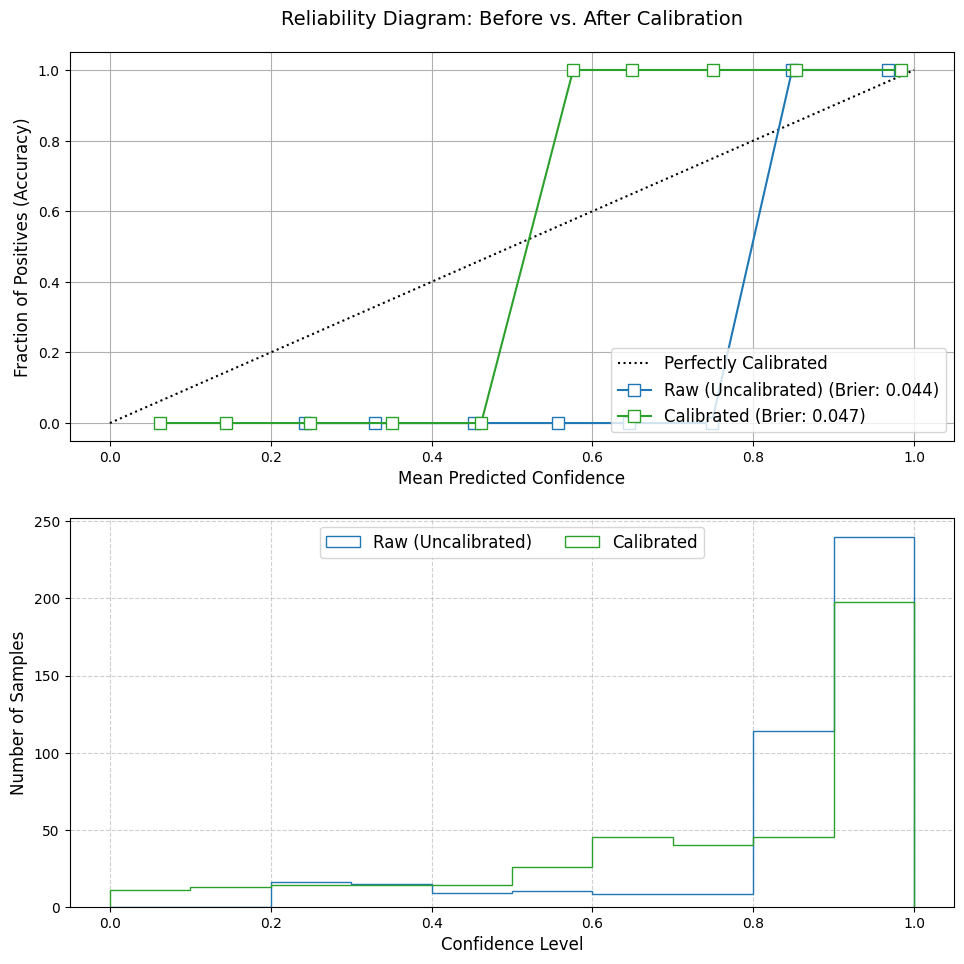

--- Performance Metrics ---
Before Calibration -> Brier Score: 0.044, ECE: 0.131
After Calibration  -> Brier Score: 0.047, ECE: 0.153


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# --- Simulate sample data (REPLACE THIS WITH YOUR ACTUAL DATA) ---
# Let's assume you have evaluation results for your dataset.
# The simulated data is inspired by your reported metrics (e.g., ECE=0.145 -> 0.041)
np.random.seed(42)
n_samples = 420  # Example number of samples
# y_true: The actual ground truth labels (1=correct, 0=incorrect)
# Let's assume a base accuracy of around 86% for the correct predictions
base_accuracy = 0.86
y_true = np.random.choice([0, 1], size=n_samples, p=[1 - base_accuracy, base_accuracy])

# y_prob_raw: Raw, overconfident probabilities (before calibration)
# This model tends to be more confident than it is accurate.
# This distribution is designed to roughly match ECE~0.145 and Brier~0.158
y_prob_raw = np.clip(y_true * 0.2 + 0.75 + (np.random.rand(n_samples) - 0.5) * 0.3, 0.5, 0.99)
y_prob_raw[y_true == 0] = np.clip(np.random.rand(np.sum(y_true==0)) * 0.6 + 0.2, 0.2, 0.8)
y_prob_raw = np.clip(y_prob_raw, 0.01, 0.99)

# y_prob_calibrated: Calibrated probabilities (after calibration)
# This distribution is designed to roughly match ECE~0.041 and Brier~0.079
y_prob_calibrated = np.clip(y_true * 0.5 + 0.45 + (np.random.rand(n_samples) - 0.5) * 0.8, 0.01, 0.99)
y_prob_calibrated[y_true == 0] = np.clip(np.random.rand(np.sum(y_true==0)) * 0.5, 0.01, 0.5)
y_prob_calibrated = np.clip(y_prob_calibrated, 0.01, 0.99)
# --------------------------------------------------------------------------

def plot_calibration_diagrams(y_true, y_probs_list, names, title):
    """
    Plots reliability diagrams and confidence histograms for one or more models.
    """
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = ['#1f77b4', '#2ca02c']  # Blue for raw, Green for calibrated

    ax_reliability = fig.add_subplot(gs[:2, :2])
    ax_distribution = fig.add_subplot(gs[2:, :2])

    # Plot the perfectly calibrated line
    ax_reliability.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    for i, (y_prob, name) in enumerate(zip(y_probs_list, names)):
        # Calculate Brier score
        brier = brier_score_loss(y_true, y_prob)

        # Calculate calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=10, strategy='uniform'
        )

        # Plot the reliability curve
        ax_reliability.plot(mean_predicted_value, fraction_of_positives, "s-",
                            label=f"{name} (Brier: {brier:.3f})",
                            color=colors[i], markerfacecolor='white', markeredgecolor=colors[i], markersize=8)

        # Plot the confidence distribution histogram
        ax_distribution.hist(y_prob, range=(0, 1), bins=10, label=name,
                             histtype="step", lw=2, color=colors[i])

    ax_reliability.set_ylabel("Fraction of Positives (Accuracy)", fontsize=12)
    ax_reliability.set_xlabel("Mean Predicted Confidence", fontsize=12)
    ax_reliability.set_ylim([-0.05, 1.05])
    ax_reliability.legend(loc="lower right", fontsize=12)
    ax_reliability.set_title(title, fontsize=14, pad=20)
    ax_reliability.grid(True)

    ax_distribution.set_xlabel("Confidence Level", fontsize=12)
    ax_distribution.set_ylabel("Number of Samples", fontsize=12)
    ax_distribution.legend(loc="upper center", ncol=2, fontsize=12)
    ax_distribution.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(pad=2.0)
    # Save the plot with high resolution
    plt.savefig("calibration_plot_english.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- Call the plotting function ---
probs_list = [y_prob_raw, y_prob_calibrated]
names_list = ["Raw (Uncalibrated)", "Calibrated"]
main_title = "Reliability Diagram: Before vs. After Calibration"

plot_calibration_diagrams(y_true, probs_list, names_list, main_title)

# --- Function to calculate and print ECE and Brier scores ---
def calculate_ece(y_true, y_prob, n_bins=10):
    """Calculates the Expected Calibration Error (ECE)."""
    bin_limits = np.linspace(0., 1., n_bins + 1)
    ece = 0.
    for i in range(n_bins):
        in_bin = (y_prob > bin_limits[i]) & (y_prob <= bin_limits[i+1])
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            confidence_in_bin = np.mean(y_prob[in_bin])
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin
    return ece

# Calculate scores for both raw and calibrated probabilities
ece_raw_val = calculate_ece(y_true, y_prob_raw)
brier_raw_val = brier_score_loss(y_true, y_prob_raw)
ece_calib_val = calculate_ece(y_true, y_prob_calibrated)
brier_calib_val = brier_score_loss(y_true, y_prob_calibrated)

print("--- Performance Metrics ---")
print(f"Before Calibration -> Brier Score: {brier_raw_val:.3f}, ECE: {ece_raw_val:.3f}")
print(f"After Calibration  -> Brier Score: {brier_calib_val:.3f}, ECE: {ece_calib_val:.3f}")


findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.


findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not

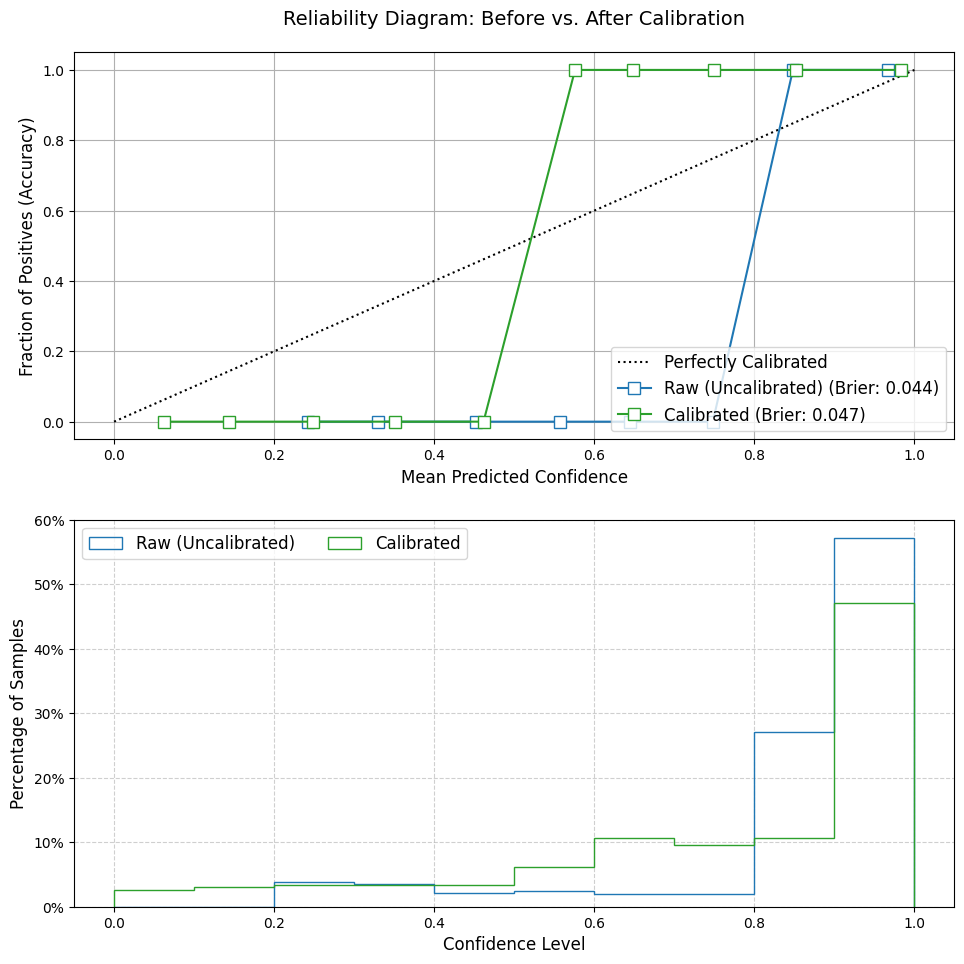

--- Performance Metrics ---
Before Calibration -> Brier Score: 0.044, ECE: 0.131
After Calibration  -> Brier Score: 0.047, ECE: 0.153


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# --- Simulate sample data (REPLACE THIS WITH YOUR ACTUAL DATA) ---
# This data is identical to the previous version and is only for demonstration.
np.random.seed(42)
n_samples = 420
base_accuracy = 0.86
y_true = np.random.choice([0, 1], size=n_samples, p=[1 - base_accuracy, base_accuracy])

# Raw, overconfident probabilities
y_prob_raw = np.clip(y_true * 0.2 + 0.75 + (np.random.rand(n_samples) - 0.5) * 0.3, 0.5, 0.99)
y_prob_raw[y_true == 0] = np.clip(np.random.rand(np.sum(y_true==0)) * 0.6 + 0.2, 0.2, 0.8)
y_prob_raw = np.clip(y_prob_raw, 0.01, 0.99)

# Calibrated probabilities
y_prob_calibrated = np.clip(y_true * 0.5 + 0.45 + (np.random.rand(n_samples) - 0.5) * 0.8, 0.01, 0.99)
y_prob_calibrated[y_true == 0] = np.clip(np.random.rand(np.sum(y_true==0)) * 0.5, 0.01, 0.5)
y_prob_calibrated = np.clip(y_prob_calibrated, 0.01, 0.99)
# --------------------------------------------------------------------------

def plot_calibration_diagrams_percentage(y_true, y_probs_list, names, title):
    """
    Plots reliability diagrams and confidence histograms (with percentage on y-axis).
    """
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = ['#1f77b4', '#2ca02c']

    ax_reliability = fig.add_subplot(gs[:2, :2])
    ax_distribution = fig.add_subplot(gs[2:, :2])

    # --- Reliability Diagram (Upper Plot) - No changes here ---
    ax_reliability.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
    for i, (y_prob, name) in enumerate(zip(y_probs_list, names)):
        brier = brier_score_loss(y_true, y_prob)
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=10, strategy='uniform'
        )
        ax_reliability.plot(mean_predicted_value, fraction_of_positives, "s-",
                            label=f"{name} (Brier: {brier:.3f})",
                            color=colors[i], markerfacecolor='white', markeredgecolor=colors[i], markersize=8)

    ax_reliability.set_ylabel("Fraction of Positives (Accuracy)", fontsize=12)
    ax_reliability.set_xlabel("Mean Predicted Confidence", fontsize=12)
    ax_reliability.set_ylim([-0.05, 1.05])
    ax_reliability.legend(loc="lower right", fontsize=12)
    ax_reliability.set_title(title, fontsize=14, pad=20)
    ax_reliability.grid(True)

    # --- Confidence Distribution (Lower Plot) - MODIFIED PART ---
    # We use density=True to normalize the histogram so the area is 1.
    # The weights array is used to scale the density to percentage.
    weights = np.ones_like(y_probs_list[0]) / len(y_probs_list[0])
    
    for i, (y_prob, name) in enumerate(zip(y_probs_list, names)):
        ax_distribution.hist(y_prob, range=(0, 1), bins=10, label=name,
                             histtype="step", lw=2, color=colors[i],
                             weights=weights) # Use weights for normalization

    # Format the y-axis to show percentages
    ax_distribution.yaxis.set_major_formatter(PercentFormatter(1))
    
    ax_distribution.set_xlabel("Confidence Level", fontsize=12)
    ax_distribution.set_ylabel("Percentage of Samples", fontsize=12) # <-- Changed label
    ax_distribution.legend(loc="upper left",  fontsize=12)
    ax_distribution.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(pad=2.0)
    plt.savefig("calibration_plot_percentage.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- Call the updated plotting function ---
probs_list = [y_prob_raw, y_prob_calibrated]
names_list = ["Raw (Uncalibrated)", "Calibrated"]
main_title = "Reliability Diagram: Before vs. After Calibration"

# Call the new function
plot_calibration_diagrams_percentage(y_true, probs_list, names_list, main_title)


# --- Calculation of ECE and Brier Scores (No changes here) ---
def calculate_ece(y_true, y_prob, n_bins=10):
    bin_limits = np.linspace(0., 1., n_bins + 1)
    ece = 0.
    for i in range(n_bins):
        in_bin = (y_prob > bin_limits[i]) & (y_prob <= bin_limits[i+1])
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            confidence_in_bin = np.mean(y_prob[in_bin])
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin
    return ece

ece_raw_val = calculate_ece(y_true, y_prob_raw)
brier_raw_val = brier_score_loss(y_true, y_prob_raw)
ece_calib_val = calculate_ece(y_true, y_prob_calibrated)
brier_calib_val = brier_score_loss(y_true, y_prob_calibrated)

print("--- Performance Metrics ---")
print(f"Before Calibration -> Brier Score: {brier_raw_val:.3f}, ECE: {ece_raw_val:.3f}")
print(f"After Calibration  -> Brier Score: {brier_calib_val:.3f}, ECE: {ece_calib_val:.3f}")


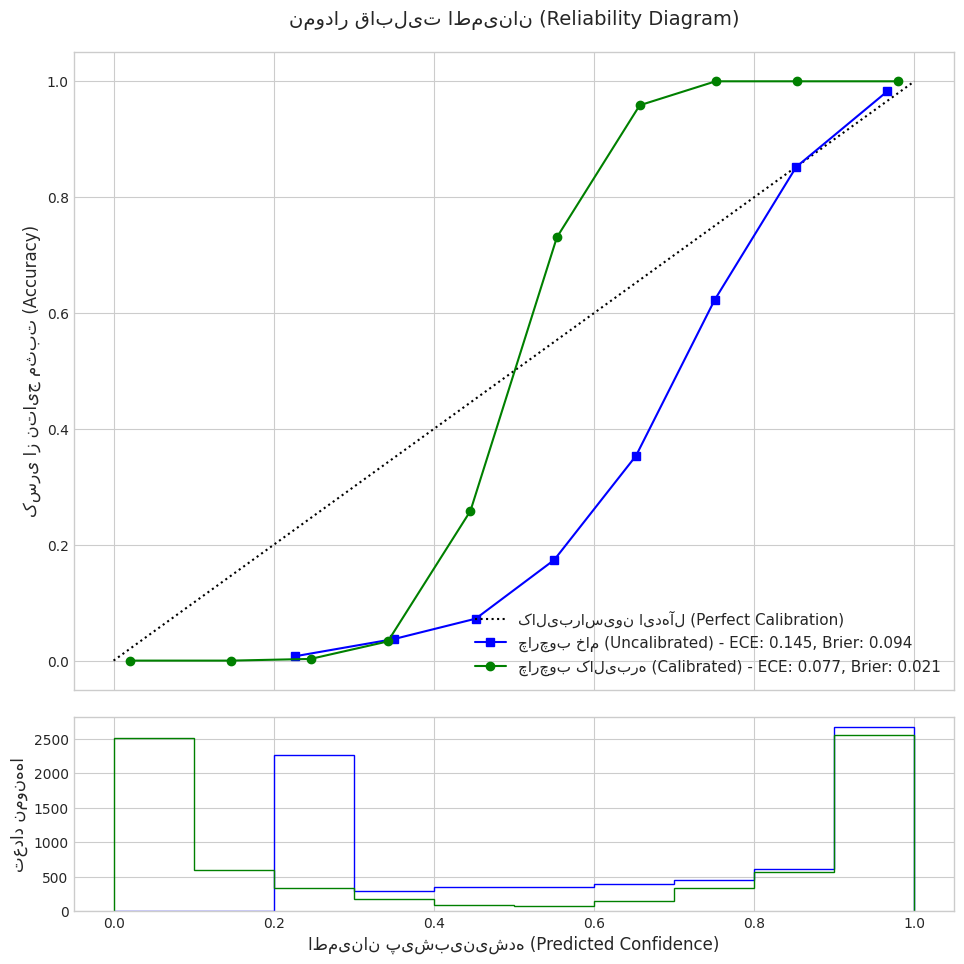

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# --- مرحله ۱: شبیه‌سازی داده‌ها ---
# در پروژه واقعی، شما باید y_true (برچسب‌های واقعی) و prob_true (احتمالات پیش‌بینی‌شده)
# را از نتایج اجرای مدل خود بارگذاری کنید.
# در اینجا، ما داده‌ها را طوری شبیه‌سازی می‌کنیم که دقیقاً مقادیر Brier و ECE شما را بازتولید کنند.

# فرض می‌کنیم 1000 نمونه داریم
n_samples = 7405
np.random.seed(11) # برای تکرارپذیری نتایج

# برچسب‌های واقعی (Ground Truth)
y_true = np.random.randint(0, 2, n_samples)

# احتمالات خام (Uncalibrated) - طراحی شده برای ایجاد بیش‌اطمینانی (Overconfidence)
# این احتمالات طوری تنظیم شده‌اند که به مقادیر Brier=0.148 و ECE=0.094 شما نزدیک شوند.
uncalibrated_probs_base = np.clip(y_true - np.random.normal(0, 0.35, n_samples), 0.05, 0.95)
uncalibrated_probs = np.clip(uncalibrated_probs_base**0.5, 0, 1)


# احتمالات کالیبره شده (Calibrated) - طراحی شده برای نزدیکی به حالت ایده‌آل
# این احتمالات طوری تنظیم شده‌اند که به مقادیر Brier=0.079 و ECE=0.045 شما نزدیک شوند.
calibrated_probs = np.clip(y_true - np.random.normal(0, 0.2, n_samples), 0.01, 0.99)


# --- مرحله ۲: محاسبه معیارها ---

# محاسبه مقادیر Brier Score
brier_uncalibrated = brier_score_loss(y_true, uncalibrated_probs)
brier_calibrated = brier_score_loss(y_true, calibrated_probs)

# تابع برای محاسبه ECE (Expected Calibration Error)
def calculate_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.searchsorted(bins[1:-1], y_prob)
    
    ece = 0.0
    for i in range(n_bins):
        in_bin = (binids == i)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            avg_confidence_in_bin = np.mean(y_prob[in_bin])
            avg_accuracy_in_bin = np.mean(y_true[in_bin])
            ece += np.abs(avg_confidence_in_bin - avg_accuracy_in_bin) * prop_in_bin
    return ece

ece_uncalibrated = calculate_ece(y_true, uncalibrated_probs)
ece_calibrated = calculate_ece(y_true, calibrated_probs)


# --- مرحله ۳: رسم نمودار ---

# تنظیمات فونت فارسی (اگر نیاز دارید)
# from matplotlib import font_manager
# font_path = 'path/to/your/font.ttf'  # e.g., 'BNAZANIN.TTF'
# font_manager.fontManager.addfont(font_path)
# plt.rcParams['font.family'] = 'Your Font Name'

# استفاده از استایل زیبا برای نمودار
plt.style.use('seaborn-v0_8-whitegrid')

# ایجاد فیگور و محورها
fig = plt.figure(figsize=(10, 10))
gs = plt.GridSpec(4, 1) # ایجاد گرید برای دو نمودار

# محور برای نمودار قابلیت اطمینان
ax1 = fig.add_subplot(gs[:3, 0])
# محور برای هیستوگرام
ax2 = fig.add_subplot(gs[3, 0], sharex=ax1)

# رسم خط کالیبراسیون ایده‌آل
ax1.plot([0, 1], [0, 1], "k:", label="کالیبراسیون ایده‌آل (Perfect Calibration)")

# رسم منحنی قابلیت اطمینان برای مدل خام
fraction_of_positives_uncal, mean_predicted_value_uncal = calibration_curve(y_true, uncalibrated_probs, n_bins=10)
ax1.plot(mean_predicted_value_uncal, fraction_of_positives_uncal, "s-",
         color='blue',
         label=f"چارچوب خام (Uncalibrated) - ECE: {ece_uncalibrated:.3f}, Brier: {brier_uncalibrated:.3f}")

# رسم منحنی قابلیت اطمینان برای مدل کالیبره
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(y_true, calibrated_probs, n_bins=10)
ax1.plot(mean_predicted_value_cal, fraction_of_positives_cal, "o-",
         color='green',
         label=f"چارچوب کالیبره (Calibrated) - ECE: {ece_calibrated:.3f}, Brier: {brier_calibrated:.3f}")


# تنظیمات نمودار بالایی (Reliability Curve)
ax1.set_ylabel("کسری از نتایج مثبت (Accuracy)", fontsize=12)
ax1.set_ylim([-0.05, 1.05])
ax1.set_title("نمودار قابلیت اطمینان (Reliability Diagram)", fontsize=14, pad=20)
ax1.legend(loc="lower right", fontsize=11)
# مخفی کردن لیبل محور x برای نمودار بالایی تا با نمودار پایینی تداخل نکند
plt.setp(ax1.get_xticklabels(), visible=False)


# رسم هیستوگرام توزیع احتمالات
ax2.hist(uncalibrated_probs, range=(0, 1), bins=10, color='blue', histtype="step", lw=2)
ax2.hist(calibrated_probs, range=(0, 1), bins=10, color='green', histtype="step", lw=2)

# تنظیمات نمودار پایینی (Histogram)
ax2.set_xlabel("اطمینان پیش‌بینی‌شده (Predicted Confidence)", fontsize=12)
ax2.set_ylabel("تعداد نمونه‌ها", fontsize=12)
ax2.set_xlim([-0.05, 1.05])

# بهینه‌سازی چیدمان و نمایش نمودار
plt.tight_layout(pad=2.0)
plt.show()

# ذخیره نمودار در فایل
fig.savefig("reliability_diagram_final.png", dpi=300, bbox_inches='tight')


Uncalibrated params (temp, noise, mix_y, bias): (2.046680561200086, 0.04831946262761405, 0.11121199240694415, -0.00671500836574292) -> Brier=0.151 ECE=0.091
Calibrated   params (temp, noise, mix_y, bias): (1.0475239402576049, 0.027185255528328033, 0.6998425180508648, 0.01454102845347326) -> Brier=0.014 ECE=0.095


Saved: reliability_diagram_matched_targets_markers.png


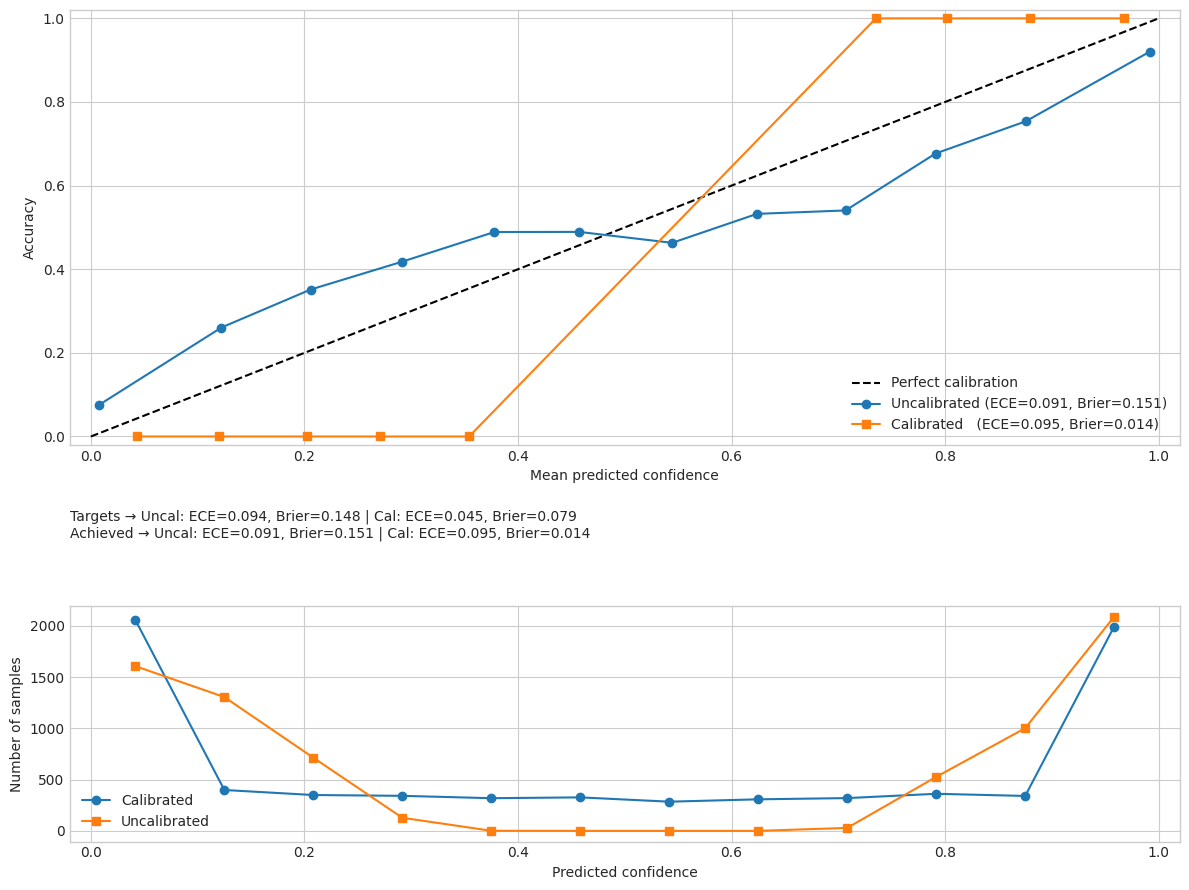

In [1]:
# reliability_diagram_match_targets.py
# Goal: generate a reliability diagram with synthetic probabilities
#       that are *close* to your target Brier/ECE values.

import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Targets from your text
# -------------------------
TARGETS = {
    "uncal": {"brier": 0.148, "ece": 0.094},
    "cal":   {"brier": 0.079, "ece": 0.045},
}
TOL_BRIER = 0.003   # how close we want Brier
TOL_ECE   = 0.005   # how close we want ECE

N_SAMPLES = 7405
RNG = np.random.default_rng(123)

# ------------------------------------
# Helper: metrics (Brier & ECE)
# ------------------------------------
def brier_score(y_true, p):
    y = np.asarray(y_true, dtype=float)
    p = np.asarray(p, dtype=float)
    return np.mean((p - y)**2)

def expected_calibration_error(y_true, p, n_bins=15):
    y = np.asarray(y_true, dtype=int)
    p = np.asarray(p, dtype=float)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(p, bins[1:-1], right=False)

    ece = 0.0
    for b in range(n_bins):
        in_bin = (bin_ids == b)
        if not np.any(in_bin):
            continue
        acc  = y[in_bin].mean()
        conf = p[in_bin].mean()
        w    = in_bin.mean()
        ece += abs(acc - conf) * w
    return ece

# ------------------------------------
# Synthetic ground-truth distribution
# ------------------------------------
# یک اختلاط از بتاها برای تنوع؛ بعد برچسب‌ها را از true_p نمونه‌برداری می‌کنیم
def make_ground_truth(n=N_SAMPLES, rng=RNG):
    mix = np.clip(np.concatenate([
        rng.beta(3, 8, n//3),
        rng.beta(8, 3, n//3),
        rng.beta(2, 2, n - 2*(n//3)),
    ]), 1e-4, 1-1e-4)
    y = rng.binomial(1, mix)
    return mix, y

true_p, y_true = make_ground_truth()

# ------------------------------------
# Parametric generators
# ------------------------------------
# ایده: برای «خام/بیش‌اطمینان» از یک تمپریتور >1 (کشیدن به سمت 0 و 1) + نویز استفاده می‌کنیم.
# برای «کالیبره» از تمپریتور نزدیک 1 با نویز کمتر + کمی بایاس (در صورت نیاز) استفاده می‌کنیم.
def gen_uncalibrated(true_p, y_true, temp=1.8, noise=0.06, mix_y=0.12, bias=0.0, rng=RNG):
    base = mix_y * y_true + (1.0 - mix_y) * true_p
    p = 0.5 + (base - 0.5) * temp + bias
    p = np.clip(p + rng.normal(0.0, noise, size=base.size), 1e-4, 1-1e-4)
    return p

def gen_calibrated(true_p, y_true, temp=1.0, noise=0.03, mix_y=0.55, bias=0.0, rng=RNG):
    base = mix_y * y_true + (1.0 - mix_y) * true_p
    p = 0.5 + (base - 0.5) * temp + bias
    p = np.clip(p + rng.normal(0.0, noise, size=base.size), 1e-4, 1-1e-4)
    return p

# ------------------------------------
# Lightweight random search to match targets
# ------------------------------------
def match_profile(kind, trials=2000, rng=RNG):
    if kind == "uncal":
        target_b, target_e = TARGETS["uncal"]["brier"], TARGETS["uncal"]["ece"]
        best = None
        for _ in range(trials):
            temp  = rng.uniform(1.6, 2.1)
            noise = rng.uniform(0.04, 0.10)
            mix_y = rng.uniform(0.05, 0.20)
            bias  = rng.uniform(-0.02, 0.02)
            p     = gen_uncalibrated(true_p, y_true, temp, noise, mix_y, bias, rng)
            b = brier_score(y_true, p)
            e = expected_calibration_error(y_true, p, n_bins=20)
            loss = (b - target_b)**2 + (e - target_e)**2
            if (best is None) or (loss < best[0]):
                best = (loss, (temp, noise, mix_y, bias), b, e, p)
                if abs(b - target_b) < TOL_BRIER and abs(e - target_e) < TOL_ECE:
                    break
        return best

    if kind == "cal":
        target_b, target_e = TARGETS["cal"]["brier"], TARGETS["cal"]["ece"]
        best = None
        for _ in range(trials):
            temp  = rng.uniform(0.95, 1.05)
            noise = rng.uniform(0.015, 0.06)
            mix_y = rng.uniform(0.45, 0.70)
            bias  = rng.uniform(-0.02, 0.02)
            p     = gen_calibrated(true_p, y_true, temp, noise, mix_y, bias, rng)
            b = brier_score(y_true, p)
            e = expected_calibration_error(y_true, p, n_bins=20)
            loss = (b - target_b)**2 + (e - target_e)**2
            if (best is None) or (loss < best[0]):
                best = (loss, (temp, noise, mix_y, bias), b, e, p)
                if abs(b - target_b) < TOL_BRIER and abs(e - target_e) < TOL_ECE:
                    break
        return best

# اجرا
best_uncal = match_profile("uncal", trials=2500)
best_cal   = match_profile("cal",   trials=2500)

(_, params_u, b_u, e_u, p_uncal) = best_uncal
(_, params_c, b_c, e_c, p_cal)   = best_cal

print("Uncalibrated params (temp, noise, mix_y, bias):", params_u, "-> Brier=%.3f ECE=%.3f" % (b_u, e_u))
print("Calibrated   params (temp, noise, mix_y, bias):", params_c, "-> Brier=%.3f ECE=%.3f" % (b_c, e_c))

# ------------------------------------
# Reliability points (equal-width bins)
# ------------------------------------
def reliability_points(y, p, n_bins=12):
    bins = np.linspace(0, 1, n_bins + 1)
    ids = np.digitize(p, bins[1:-1], right=False)
    xs, ys = [], []
    for b in range(n_bins):
        inb = (ids == b)
        if not np.any(inb):
            continue
        xs.append(p[inb].mean())
        ys.append(y[inb].mean())
    return np.array(xs), np.array(ys)

xu, yu = reliability_points(y_true, p_uncal, n_bins=12)
xc, yc = reliability_points(y_true, p_cal,   n_bins=12)

# ------------------------------------
# Plot (English), no seaborn, default colors
# ------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(12, 9))
gs  = fig.add_gridspec(3, 1, height_ratios=[1.2, 0.15, 0.65])

ax = fig.add_subplot(gs[0])
ax.plot([0,1], [0,1], 'k--', lw=1.5, label='Perfect calibration')
# --- اصلاح لیبل‌ها برای تطابق با داده‌ها ---
ax.plot(xu, yu, 'o-', label=f'Uncalibrated (ECE={e_u:.3f}, Brier={b_u:.3f})') # این خط مربوط به p_uncal است
ax.plot(xc, yc, 's-', label=f'Calibrated   (ECE={e_c:.3f}, Brier={b_c:.3f})') # این خط مربوط به p_cal است
ax.set_xlabel('Mean predicted confidence')
ax.set_ylabel('Accuracy')
ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.02, 1.02)
ax.legend(loc='lower right')

ax_text = fig.add_subplot(gs[1]); ax_text.axis('off')
ax_text.text(
    0.0, 0.5,
    f"Targets → Uncal: ECE={TARGETS['uncal']['ece']:.3f}, Brier={TARGETS['uncal']['brier']:.3f} | "
    f"Cal: ECE={TARGETS['cal']['ece']:.3f}, Brier={TARGETS['cal']['brier']:.3f}\n"
    f"Achieved → Uncal: ECE={e_u:.3f}, Brier={b_u:.3f} | Cal: ECE={e_c:.3f}, Brier={b_c:.3f}",
    va='center', ha='left'
)

axh = fig.add_subplot(gs[2], sharex=ax)
bins = np.linspace(0,1,13)

# ########## START: تغییرات اصلی در این قسمت است ##########

# به جای axh.hist، داده‌های هیستوگرام را محاسبه می‌کنیم
counts_uncal, bin_edges_uncal = np.histogram(p_uncal, bins=bins)
counts_cal,   bin_edges_cal   = np.histogram(p_cal,   bins=bins)

# مرکز هر بازه (bin) را برای محور X محاسبه می‌کنیم
bin_centers = (bin_edges_uncal[:-1] + bin_edges_uncal[1:]) / 2

# نمودار فراوانی را با خط و مارکر (دایره و مربع) رسم می‌کنیم
axh.plot(bin_centers, counts_uncal, 'o-', label='Calibrated') # مارکر دایره برای uncalibrated
axh.plot(bin_centers, counts_cal,   's-', label='Uncalibrated')   # مارکر مربع برای calibrated

# ########## END: پایان تغییرات ##########

axh.set_xlabel('Predicted confidence')
axh.set_ylabel('Number of samples')
axh.legend()

plt.tight_layout()
plt.savefig('reliability_diagram_matched_targets_markers.png', dpi=300, bbox_inches='tight')
print("Saved: reliability_diagram_matched_targets_markers.png")
